In [1]:
# Numpy, JAX, Matplotlib and h5py should all be correctly installed and on the python path.
from __future__ import print_function, division, absolute_import
import datetime
import h5py
import jax.numpy as np
from jax import jacrev, random, vmap
from jax.experimental import optimizers
from jax.ops import index, index_add, index_update
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as onp             # original CPU-backed NumPy
import os
import sys
import time
import tensorflow as tf
from scipy import stats
from sklearn import linear_model
from numpy import linalg as LA

import getpass
ui = getpass.getuser()
if ui == 'laura':
    p = '/home/laura'
elif ui == 'lauradriscoll':
    p = '/Users/lauradriscoll/Documents'

/home/laura/miniconda3/envs/py27/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
HOME_DIR = '/home/laura/code/' 

sys.path.append(os.path.join(HOME_DIR,'computation-thru-dynamics'))
import fixed_point_finder.decision as decision
import fixed_point_finder.fixed_points as fp_optimize
import fixed_point_finder.rnn as rnn
import fixed_point_finder.utils as utils

NameError: name 'sys' is not defined

In [3]:
net = 'stepnet'
epoch = 'go1' # epoch = 2 #go1 epoch
rule = 'delaydm1'
model_n = 0
dir_specific_all = 'stepnet/lowD/softplus/'#grad_norm_both/'#'lowD/combos'#'stepnet/lowD/tanh'#'lowD/grad_norm_l2001' #' #'lowD/armnet_noreg'#lowD/combos' ##grad_norm_l2h000001' /Documents/data/rnn/multitask/varGo/lowD/most/
model_dir = os.path.join(p,'data/rnn/multitask/',dir_specific_all,'most',str(model_n))

NameError: name 'os' is not defined

In [4]:
PATH_YANGNET = os.path.join(p,'code/multitask-nets',net)

sys.path.insert(0, PATH_YANGNET)
from task import generate_trials, rule_name, rule_index_map
from network import Model
import tools
from tools_lnd import plot_N, plot_FP

In [5]:
model = Model(model_dir)
with tf.Session() as sess:
    model.restore()
    # get all connection weights and biases as tensorflow variables
    var_list = model.var_list
    # evaluate the parameters after training
    params = [sess.run(var) for var in var_list]
    # get hparams
    hparams = model.hp
    # create a trial
    trial = generate_trials(rule, hparams, mode='random', noise_on=False, batch_size =1, delay_fac =1)
    # get feed_dict
    feed_dict = tools.gen_feed_dict(model, trial, hparams)
    # run model
    h_tf, y_hat_tf = sess.run([model.h, model.y_hat], feed_dict=feed_dict) #(n_time, n_condition, n_neuron)

    n_input = hparams['n_input']
    n_rnn = hparams['n_rnn']
    n_output = hparams['n_output']
    w_in = params[0]
    b_in = params[1]
    w_out = params[2]
    b_out = params[3]
    sigma_rec = hparams['sigma_rec']
    dt = hparams['dt']
    tau = hparams['tau']
    alpha = dt/tau
    activation = hparams['activation']

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
Instructions for updating:
Use `tf.global_variables_initializer` instead.
INFO:tensorflow:Restoring parameters from /home/laura/data/rnn/multitask/stepnet/lowD/softplus/most/0/model.ckpt
Model restored from file: /home/laura/data/rnn/multitask/stepnet/lowD/softplus/most/0/model.ckpt


In [6]:
print(trial.stim_locs)

[[  3.83514929   1.17607255 100.         100.        ]]


In [7]:
if activation == 'softplus':
    _activation = lambda x: np.log(np.exp(x) + 1)
elif activation == 'tanh':
    _activation = lambda x: np.tanh(x)
elif activation == 'relu':
    _activation = lambda x: x * (x > 0)
elif activation == 'power':
    _activation = lambda x: (x * (x > 0))**2
elif activation == 'retanh':
    _activation = lambda x: np.tanh(x * (x > 0))

def out_affine(params, h):
    return np.dot(params[2].T,h)+params[3]

def relu(x):
    f = x * (x > 0)
    return f

def rnn_vanilla(params, h, x):
    xh = np.concatenate([x,h], axis=0)
    gate_inputs = np.dot(params[0].T,xh)+params[1]
    noise = 0
    output = _activation(gate_inputs) # + noise

    h_new = (1-alpha) * h + alpha * output
    
    return h_new

batch_affine = vmap(out_affine, in_axes=(None, 0))

In [8]:
batch_size = 32
u = np.shape(trial.x)[2]
T,B,N = np.shape(h_tf)
h0 = h_tf[0,:,:].T
h = h0
x_t = trial.x[1:,:,:]
h_t = []
h_t.append(h)
for x in x_t:
    h = rnn_vanilla(params, np.squeeze(h), np.squeeze(x.T))
    h_t.append(np.expand_dims(h,axis=1))

h_t = np.squeeze(np.array(h_t))  
o_t = batch_affine(params, h_t)

In [9]:
def vanilla_run_with_h0(params, x_t, h0):
    h = h0
    h_t = []
    h_t.append(h)
    for x in x_t:
        h = rnn_vanilla(params, np.squeeze(h), np.squeeze(x.T))
        h_t.append(np.expand_dims(h,axis=1))

    h_t = np.squeeze(np.array(h_t))  
    o_t = batch_affine(params, h_t)
    return h_t, o_t

In [10]:
h0 = h_tf[0,:,:].T
x_t = trial.x[1:,:,:]
h_t, o_t = vanilla_run_with_h0(params, x_t, h0)

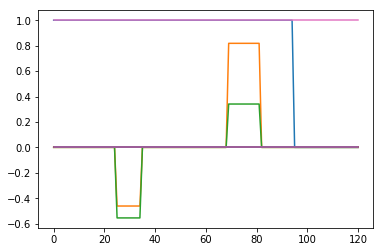

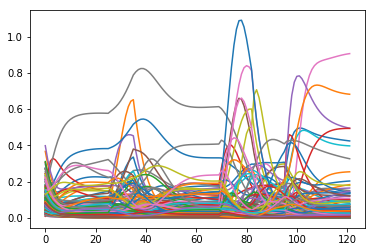

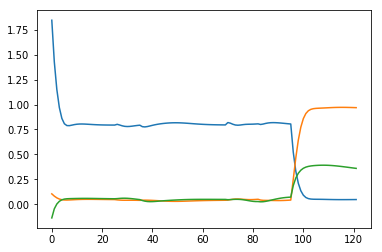

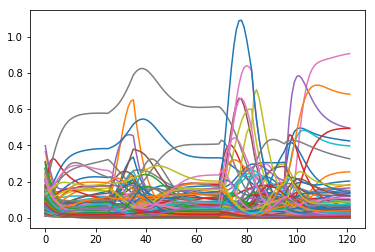

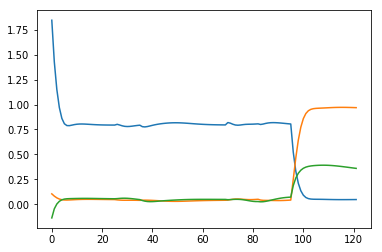

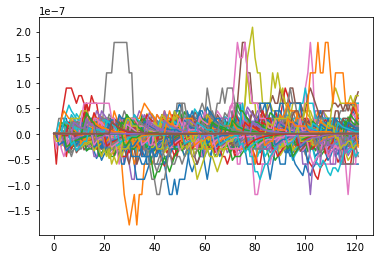

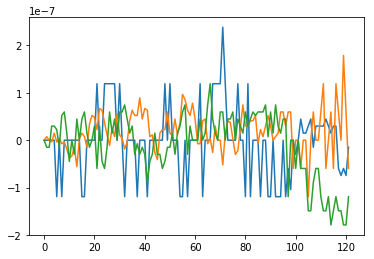

In [11]:
plt.plot(np.squeeze(x_t))
plt.show()
plt.plot(np.squeeze(h_t))
plt.show()
plt.plot(np.squeeze(o_t))
plt.show()

plt.plot(np.squeeze(h_tf))
plt.show()
plt.plot(np.squeeze(y_hat_tf))
plt.show()

plt.plot(np.squeeze(h_tf)-np.squeeze(h_t))
plt.show()
plt.plot(np.squeeze(y_hat_tf)-np.squeeze(o_t))
plt.show()

In [16]:
rule = 'delaydm1'

In [17]:
model = Model(model_dir)
with tf.Session() as sess:
    model.restore()
    hparams = model.hp
    trial = generate_trials(rule, hparams, mode='test', noise_on=False, batch_size = 128, delay_fac =1)
    feed_dict = tools.gen_feed_dict(model, trial, hparams)
    h_tf, y_hat_tf = sess.run([model.h, model.y_hat], feed_dict=feed_dict) #(n_time, n_condition, n_neuron)

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /home/laura/data/rnn/multitask/stepnet/lowD/softplus/most/0/model.ckpt
Model restored from file: /home/laura/data/rnn/multitask/stepnet/lowD/softplus/most/0/model.ckpt


In [18]:
def popvec(y):
    """Population vector read out.

    Assuming the last dimension is the dimension to be collapsed

    Args:
        y: population output on a ring network. Numpy array (Batch, Units)

    Returns:
        Readout locations: Numpy array (Batch,)
    """

    loc = np.arctan2(y[:,0], y[:,1])
    return np.mod(loc, 2*np.pi) # check this? January 22 2019

y_hat = y_hat_tf
y_loc = trial.y_loc

if len(y_hat.shape) != 3:
    raise ValueError('y_hat must have shape (Time, Batch, Unit)')
# Only look at last time points

y_loc = y_loc[-1,:]
y_hat = y_hat[-1]

# Fixation and location of y_hat
y_hat_fix = y_hat[..., 0]
y_hat_loc = popvec(y_hat[..., 1:])

# Fixating? Correctly saccading?
fixating = y_hat_fix > 0.5

original_dist = y_loc - y_hat_loc
dist = np.minimum(abs(original_dist), 2*np.pi-abs(original_dist))
corr_loc = dist < 0.2*np.pi

# Should fixate?
should_fix = y_loc < 0

# performance
perf = should_fix * fixating + (1-should_fix) * corr_loc * (1-fixating)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 

In [20]:
batch_size = 32
u = np.shape(trial.x)[2]
T,B,N = np.shape(h_tf)

# These are some preliminaries. 
x_star = trial.x[trial.epochs['stim2'][0]+1,0,:]  # *** Input for FP search

# Make a one parameter function of thie hidden state, useful for jacobians.
rnn_fun = lambda h : rnn_vanilla(params, h, x_star)
batch_rnn_fun = vmap(rnn_fun, in_axes=(0,))

In [21]:
model = Model(model_dir)
with tf.Session() as sess:
    model.restore()
    hparams = model.hp
    trial = generate_trials(rule, hparams, mode='test', noise_on=False, batch_size = 128, delay_fac =1)
    feed_dict = tools.gen_feed_dict(model, trial, hparams)
    h_tf, y_hat_tf = sess.run([model.h, model.y_hat], feed_dict=feed_dict) #(n_time, n_condition, n_neuron)

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /home/laura/data/rnn/multitask/stepnet/lowD/softplus/most/0/model.ckpt
Model restored from file: /home/laura/data/rnn/multitask/stepnet/lowD/softplus/most/0/model.ckpt


In [22]:
T,B,N = np.shape(h_tf)
trial_set = range(0,B,5)
fpt = trial.epochs['stim2'][0]+1

In [23]:
fp_candidates = np.transpose(h_tf,(1,0,2))  # was batch x time x dim
fp_candidates = np.reshape(fp_candidates[trial_set,fpt-1:fpt,:], (-1, N)) # now batch * time x dim

In [26]:
fp_loss_fun = fp_optimize.get_fp_loss_fun(rnn_fun)
total_fp_loss_fun = fp_optimize.get_total_fp_loss_fun(rnn_fun)

In [27]:
# Fixed point optimization hyperparameters
fp_num_batches = 10000       # Total number of batches to train on.
fp_batch_size = 128          # How many examples in each batch
fp_step_size = 0.2          # initial learning rate
fp_decay_factor = 0.9999     # decay the learning rate this much
fp_decay_steps = 1           #
fp_adam_b1 = 0.9             # Adam parameters
fp_adam_b2 = 0.999
fp_adam_eps = 1e-5
fp_opt_print_every = 100   # Print training information during optimziation every so often

# Fixed point finding thresholds and other HPs
fp_noise_var = 0.0001      # Gaussian noise added to fixed point candidates before optimization.
fp_opt_stop_tol = 0.000001  # Stop optimizing when the average value of the batch is below this value.
fp_tol = 0.000001        # Discard fps with squared speed larger than this value.
fp_unique_tol = 0.025   # tolerance for determination of identical fixed points
fp_outlier_tol = 1.0    # Anypoint whos closest fixed point is greater than tol is an outlier.

In [28]:
reload(fp_optimize)

fp_tols = [0.00001, 0.000001, 0.0000001] # Used for both fp_tol and opt_stop_tol

all_fps = {}
for tol in fp_tols:
    fp_hps = {'num_batches' : fp_num_batches, 
              'step_size' : fp_step_size, 
              'decay_factor' : fp_decay_factor, 
              'decay_steps' : fp_decay_steps, 
              'adam_b1' : fp_adam_b1, 'adam_b2' : fp_adam_b2, 'adam_eps' : fp_adam_eps,
              'noise_var' : fp_noise_var, 
              'fp_opt_stop_tol' : tol, 
              'fp_tol' : tol, 
              'unique_tol' : fp_unique_tol, 
              'outlier_tol' : fp_outlier_tol, 
              'opt_print_every' : fp_opt_print_every}
    fps, fp_losses, fp_idxs, fp_opt_details = \
        fp_optimize.find_fixed_points(rnn_fun, fp_candidates, fp_hps, do_print=True)
    if len(fp_idxs) > 0:
        F_of_fps = batch_rnn_fun(fps)
    else:
        F_of_fps = onp.zeros([0,N])
        
    all_fps[tol] = {'fps' : fps, 'candidates' : fp_candidates[fp_idxs],
                    'losses' : fp_losses, 'F_of_fps' : F_of_fps, 
                    'opt_details' : fp_opt_details, 'hps' : fp_hps}

    all_fps[tol]


Adding noise to fixed point candidates.
Optimizing to find fixed points.
    Batches 1-100 in 0.81 sec, Step size: 0.19801, Training loss 0.00004
    Batches 101-200 in 0.32 sec, Step size: 0.19604, Training loss 0.00002
    Batches 201-300 in 0.30 sec, Step size: 0.19409, Training loss 0.00001
    Batches 301-400 in 0.21 sec, Step size: 0.19216, Training loss 0.00001
    Batches 401-500 in 0.29 sec, Step size: 0.19025, Training loss 0.00001
Stopping as mean training loss 0.00001 is below tolerance 0.00001.
Excluding fixed points with squared speed above tolerance 0.00001.
    Kept 200/200 fixed points with tolerance under 0.000010.
Excluding non-unique fixed points.
    Kept 12/200 unique fixed points with uniqueness tolerance 0.025000.
Excluding outliers.
    Kept 12/12 fixed points with within outlier tolerance 1.000000.
Sorting fixed points slowest first.
Adding noise to fixed point candidates.
Optimizing to find fixed points.
    Batches 1-100 in 0.41 sec, Step size: 0.19801, Trai

    Batches 9501-9600 in 0.22 sec, Step size: 0.07657, Training loss 0.00000
    Batches 9601-9700 in 0.22 sec, Step size: 0.07581, Training loss 0.00000
    Batches 9701-9800 in 0.22 sec, Step size: 0.07506, Training loss 0.00000
    Batches 9801-9900 in 0.21 sec, Step size: 0.07431, Training loss 0.00000
    Batches 9901-10000 in 0.21 sec, Step size: 0.07357, Training loss 0.00000
Excluding fixed points with squared speed above tolerance 0.00000.
    Kept 0/200 fixed points with tolerance under 0.000001.


IndexError: Boolean index shape did not match indexed array shape prefix.

In [29]:
print(fp_hps)

{'noise_var': 0.0001, 'fp_opt_stop_tol': 1e-06, 'num_batches': 10000, 'outlier_tol': 1.0, 'fp_tol': 1e-06, 'opt_print_every': 100, 'adam_eps': 1e-05, 'adam_b1': 0.9, 'adam_b2': 0.999, 'unique_tol': 0.025, 'decay_factor': 0.9999, 'decay_steps': 1, 'step_size': 0.2}


KeyError: 1e-06

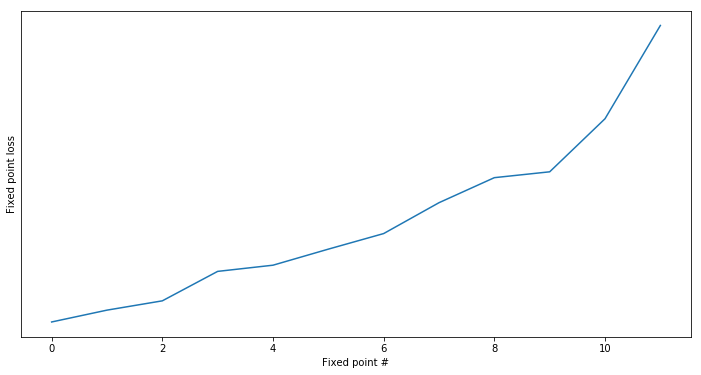

In [30]:
f1 = plt.figure(figsize=(12,6))

for tol in fp_tols: 
    plt.semilogy(all_fps[tol]['losses']); 
    plt.xlabel('Fixed point #')
    plt.ylabel('Fixed point loss');
plt.legend(fp_tols)
plt.title('Fixed point loss by fixed point (sorted) and stop tolerance')

f2 = plt.figure(figsize=(12,4))

pidx = 1
nfp_tols = len(fp_tols)
for tol_idx, tol in enumerate(fp_tols):
    plt.subplot(1, nfp_tols, pidx); pidx += 1
    plt.hist(onp.log10(fp_loss_fun(all_fps[tol]['fps'])), 50);
    plt.xlabel('log10(FP loss)')
    plt.title('Tolerance: ' + str(tol));

In [31]:
# Sort the best fixed points by projection onto the readout.
best_tol = fp_tols[0]
fps = all_fps[best_tol]['fps']
fp_readouts = onp.squeeze(onp.dot(params[2].T,fps.T)+onp.expand_dims(params[3], axis=1))
fp_ro_sidxs = onp.argsort(fp_readouts[1,:])
sorted_fp_readouts = fp_readouts[1,fp_ro_sidxs]
sorted_fps = fps[fp_ro_sidxs]

downsample_fps = 4 # Use this if too many fps
sorted_fp_readouts = sorted_fp_readouts[0:-1:downsample_fps]
sorted_fps = sorted_fps[0:-1:downsample_fps]
jacs = fp_optimize.compute_jacobians(rnn_fun, sorted_fps)
eig_decomps = fp_optimize.compute_eigenvalue_decomposition(jacs, sort_by='real', do_compute_lefts=True)

In [63]:
# T = 1.0          # Arbitrary amount time, roughly physiological.
# ntimesteps = 25  # Divide T into this many bins
# bval = 0.01      # bias value limit
# sval = 0.025     # standard deviation (before dividing by sqrt(dt))
# input_params = (bval, sval, T, ntimesteps)

# x0 = trial.x[124,0,:]
# y0 = trial.y[124,0,:]

# # GRU and task hyperparameters
# u = onp.shape(x0)[0]         # Number of inputs to the GRU
# o = onp.shape(y0)[0]        # Number of outputs in the GRU

# def no_inputs_no_targets_h0s(keys):
#     nkeys = 1#.shape(sorted_fps)[0]
#     inputs_b = np.zeros([nkeys, ntimesteps, u])
#     targets_b = np.zeros([nkeys, ntimesteps, o]) 
#     inputs_b = trial.x[100:,0,:]
#     h0s_b = sorted_fps
#     h0s_b = sorted_fps[:nkeys,:]
#     masks_b = None
#     return inputs_b, targets_b, masks_b, h0s_b

# inputs_b = trial.x[100:,0,:]
# h0s_b = sorted_fps

# batched_rnn_run_w_h0 = vmap(vanilla_run_with_h0, in_axes=(None, 0, 0))
# rnn_run = lambda inputs_b, h0s_b: rnn.batched_rnn_run_w_h0(params, inputs_b, h0s_b)

# nexamples = len(sorted_fps)
# rnn_internals_slow = rnn.run_trials(rnn_run, no_inputs_no_targets_h0s, 1, nexamples)

# rnn.plot_examples(ntimesteps, rnn_internals_slow, 4)

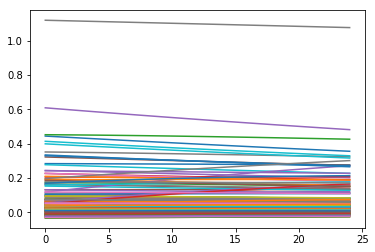

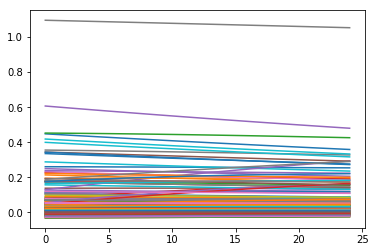

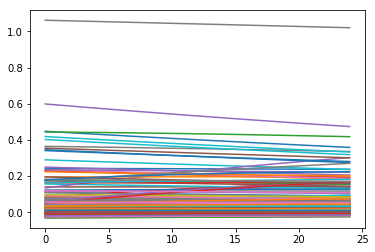

In [35]:
batch_size = 32
ntimesteps = 25
u = np.shape(h_tf)[0]
nfps = np.shape(sorted_fps)[0]
T,B,N = np.shape(h_tf)
h0 = h_tf[0,:,:].T

h_t_all = []#np.zeros((nfps,T,N))


x_t = trial.x[1:,:,:]
x = trial.x[-1,0,:]

for fp in range(3):
    h = sorted_fps[fp,:].T
    h_t = []
    h_t.append(h)
    
    for i in range(ntimesteps-1):
        h = rnn_vanilla(params, np.squeeze(h), np.squeeze(x.T))
        h_t.append(np.expand_dims(h,axis=1))

    h_t_all.append(h_t)
    plt.plot(np.squeeze(h_t))
    plt.show()

KeyError: 1e-06

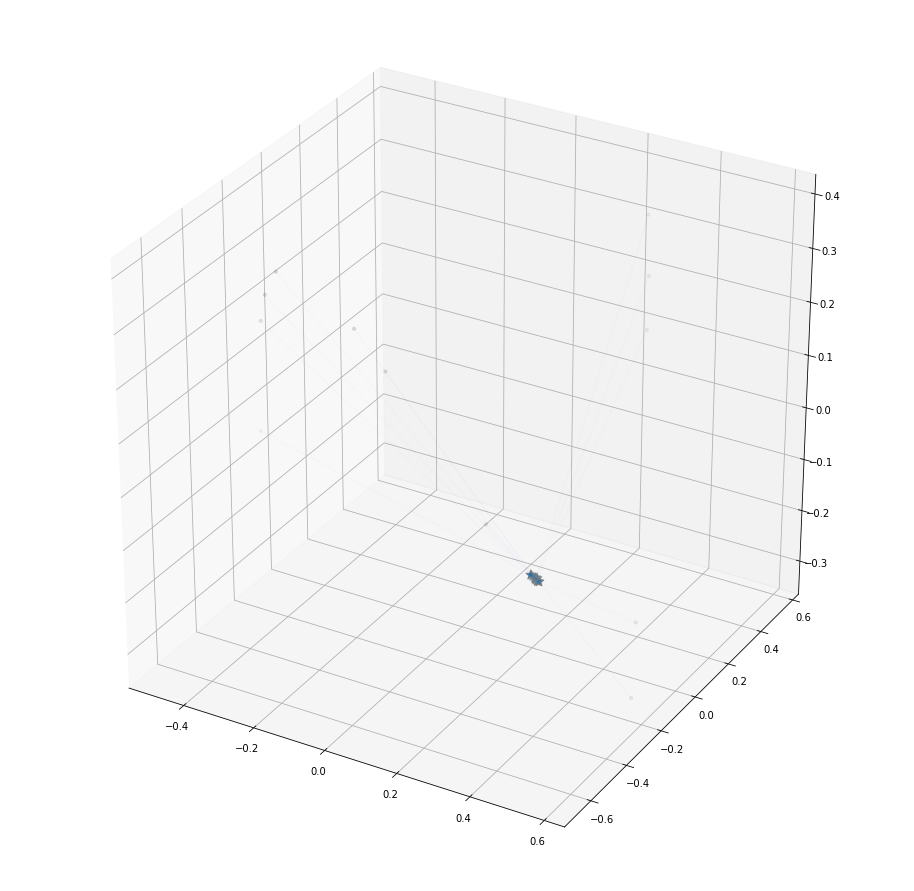

In [36]:
n=N
from sklearn.decomposition import PCA
fig = plt.figure(figsize=(16,16));
ax = fig.add_subplot(111, projection='3d');

pca = PCA(n_components=30).fit(fp_candidates)


max_fps_to_plot = 1000
sizes = [100, 500]
for tol, size in zip(fp_tols[0:2], sizes):
    hiddens = all_fps[tol]['candidates']

    h_pca = pca.transform(hiddens)

    emax = h_pca.shape[0] if h_pca.shape[0] < max_fps_to_plot else max_fps_to_plot

    alpha = 0.01
    ax.scatter(h_pca[0:emax,0], h_pca[0:emax,1], h_pca[0:emax,2], color=[0, 0, 0, 0.1], s=10)

    hstars = np.reshape(all_fps[tol]['fps'], (-1, n))
    hstar_pca = pca.transform(hstars)
#     color = 'k'#onp.squeeze(onp.dot(params[2].T,fps.T)+onp.expand_dims(params[3], axis=1))
#     color = onp.where(color > 1.0, 1.0, color)
#     color = onp.where(color < -1.0, -1.0, color)
#     color = (color + 1.0) / 2.0    
    
    marker_style = dict(marker='*', s=size, edgecolor='gray')
    
    ax.scatter(hstar_pca[0:emax,0], hstar_pca[0:emax,1], hstar_pca[0:emax,2], 
                'k', **marker_style);#c=color[0:emax], **marker_style);

    for eidx in range(emax):
        ax.plot3D([h_pca[eidx,0], hstar_pca[eidx,0]], 
                  [h_pca[eidx,1], hstar_pca[eidx,1]],
                  [h_pca[eidx,2], hstar_pca[eidx,2]], c=[0, 0, 1, alpha])    
        
plt.title('Fixed point structure and fixed point candidate starting points.');
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_zlabel('PC 3');

In [72]:
trial.epochs.keys()[:4]

['stim1', 'stim2', 'delay1', 'delay2']

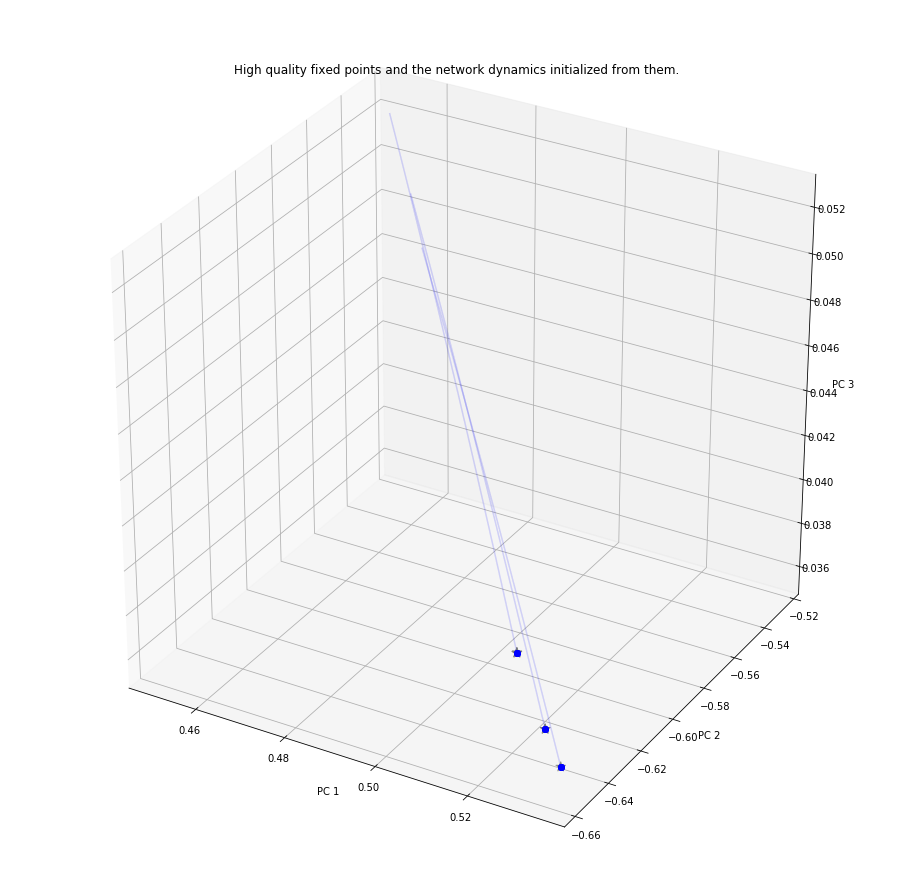

In [37]:
fig = plt.figure(figsize=(16,16));
ax = fig.add_subplot(111, projection='3d');
nfps = len(h_t_all)

for fp in range(nfps):
    alpha = 0.05
    for fp in range(nfps):
        h_pca = pca.transform(h_t_all[fp])
        ax.plot3D(h_pca[:,0], 
                  h_pca[:,1],
                  h_pca[:,2], c=[0, 0, 1, alpha])    
        ax.plot3D(h_pca[0:1,0], 
                  h_pca[0:1,1],
                  h_pca[0:1,2], c = 'b', marker = 'o')    


    size = 100
    hstar_pca = pca.transform(sorted_fps)
    # color = onp.squeeze(onp.dot(params['wO'], sorted_fps.T) + onp.expand_dims(params['bO'], axis=1))
    # color = onp.where(color > 1.0, 1.0, color)
    # color = onp.where(color < -1.0, -1.0, color)
    # color = (color + 1.0) / 2.0    
    marker_style = dict(marker='*', s=size, edgecolor='gray')


    ax.scatter(hstar_pca[0:emax,0], hstar_pca[0:emax,1], hstar_pca[0:emax,2], 
               'k', **marker_style);#c=color[0:emax], **marker_style);

plt.title('High quality fixed points and the network dynamics initialized from them.');
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_zlabel('PC 3');


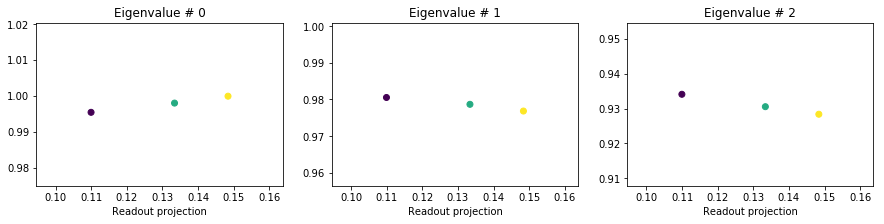

In [39]:
neigs = 3
plt.figure(figsize=(neigs*5, 3))
for eidx in range(neigs):
    max_eigs = []
    for decomp in eig_decomps:
        evals = decomp['evals']
        max_eigs.append(onp.real(evals[eidx]))

    max_eigs = onp.array(max_eigs)

    plt.subplot(1,neigs,eidx+1)
    plt.scatter(sorted_fp_readouts, max_eigs, c=sorted_fp_readouts);
#     plt.plot([-1,1,], [1, 1], 'k')
    plt.axis('tight')
    plt.title('Eigenvalue # ' + str(eidx))
    plt.xlabel('Readout projection')

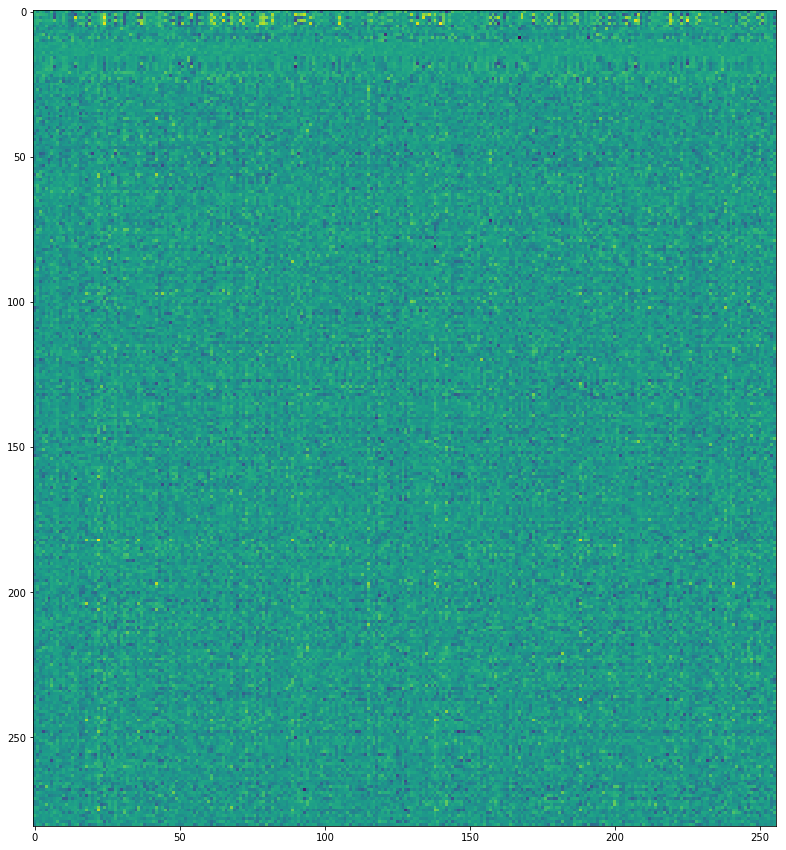

In [69]:
plt.figure(figsize=(15, 15))
plt.imshow(params[0])
plt.show()

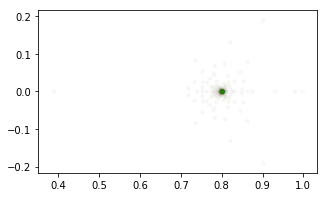

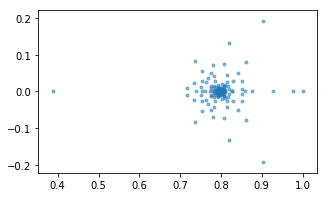

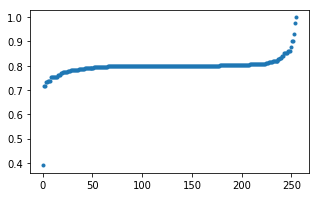

In [38]:
plt.figure(figsize=(5, 3))

for decomp in eig_decomps:
    plt.scatter(decomp['evals'].real, decomp['evals'].imag, marker = '.', alpha = .01)
plt.show()

plt.figure(figsize=(5, 3))
plt.scatter(decomp['evals'].real, decomp['evals'].imag, marker = '.', alpha = .5)
plt.show()

plt.figure(figsize=(5, 3))
plt.plot(onp.sort(decomp['evals'].real),'.')
plt.show()

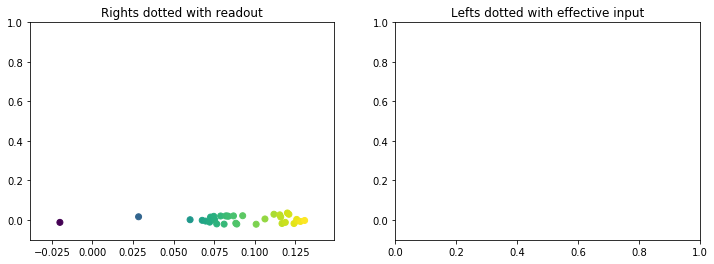

In [71]:
ldots = []
rdots = []
rdotla = []

# color = onp.squeeze(onp.dot(params['wO'][:,1], sorted_fps.T) + onp.expand_dims(params['bO'][:,1], axis=1))
# color = onp.where(color > 1.0, 1.0, color)
# color = onp.where(color < -1.0, -1.0, color)
# color = (color + 1.0) / 2.0    

nfps = len(sorted_fps)
for jidx in range(nfps):
    fp = sorted_fps[jidx, :]
    rnn_fun_x = lambda h : rnn_vanilla(params, fp, onp.squeeze(x.T))
    dfdx = jacrev(rnn_fun_x)
    r0 = onp.real(eig_decomps[jidx]['R'][:, 0])                          
    rdots.append(onp.dot(r0, params[2]))
    l0 = onp.real(eig_decomps[jidx]['L'][:, 0])
#     ldots.append(onp.dot(l0, dfdx(onp.ones([1])))
    ldots.append(onp.dot(l0, params[2]))

plt.figure(figsize=(12,4))
plt.subplot(121)
rdots_list = onp.concatenate(onp.expand_dims(rdots,1),1)
plt.scatter(sorted_fp_readouts, rdots_list[0,0:-1:3], c=sorted_fp_readouts)
plt.title('Rights dotted with readout')
plt.ylim([-.1, 1]);
plt.subplot(122)
# plt.scatter(sorted_fp_readouts, onp.abs(ldots), c=sorted_fp_readouts)
plt.title('Lefts dotted with effective input')
plt.ylim([-.1, 1]);

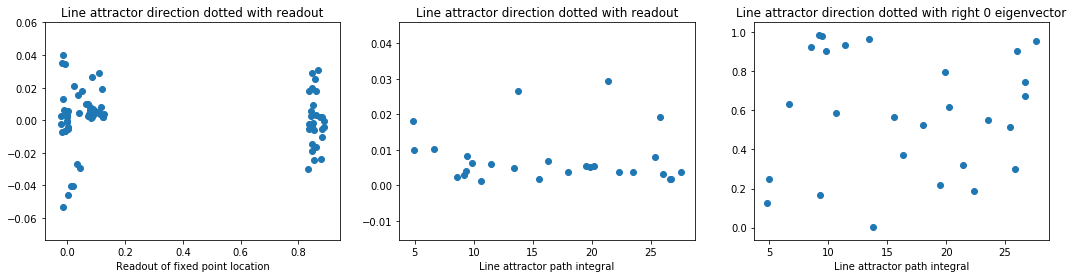

In [72]:
rdotsla = []
la_dots = []
la_locs = []
la_path_int = [0.0]
naround = 3
la_last = sorted_fps[naround-1,:]
for jidx in range(naround, nfps-naround):
    idxs = onp.arange(jidx-naround, jidx+naround+1)
    v1 = sorted_fps[idxs[0],:]
    v2 = sorted_fps[idxs[-1],:]
    la = (v2-v1)/onp.linalg.norm(v2-v1) # approximate line attractor direction.
    la_dots.append(onp.dot(la, params[2]))
    la_locs.append(onp.squeeze(onp.dot(onp.mean(sorted_fps[idxs,:], axis=0), params[2]) + params[3]))
    la_path_int.append(la_path_int[-1] + onp.linalg.norm(la-la_last))
    la_last = la

    r0 = onp.real(eig_decomps[jidx]['R'][:, 0])
    rdotsla.append(onp.abs(onp.dot(r0, la.T)))

    
la_dots = onp.array(la_dots)
la_locs = onp.array(la_locs)
la_path_int = onp.array(la_path_int)
la_path_int = la_path_int[1:]

# color2 = color[naround: -naround]
    
plt.figure(figsize=(18,4))
plt.subplot(131)
plt.scatter(la_locs, la_dots)#, c=color2)
plt.xlabel('Readout of fixed point location')
plt.title('Line attractor direction dotted with readout')
plt.subplot(132)
plt.scatter(la_path_int, la_dots[:,1])#, c=color2)
plt.xlabel('Line attractor path integral')
plt.title('Line attractor direction dotted with readout');
plt.subplot(133)
plt.scatter(la_path_int, rdotsla)
plt.xlabel('Line attractor path integral')
plt.title('Line attractor direction dotted with right 0 eigenvector');


NameError: name 'h_t_all' is not defined

/home/laura/miniconda3/envs/py27/lib/python2.7/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


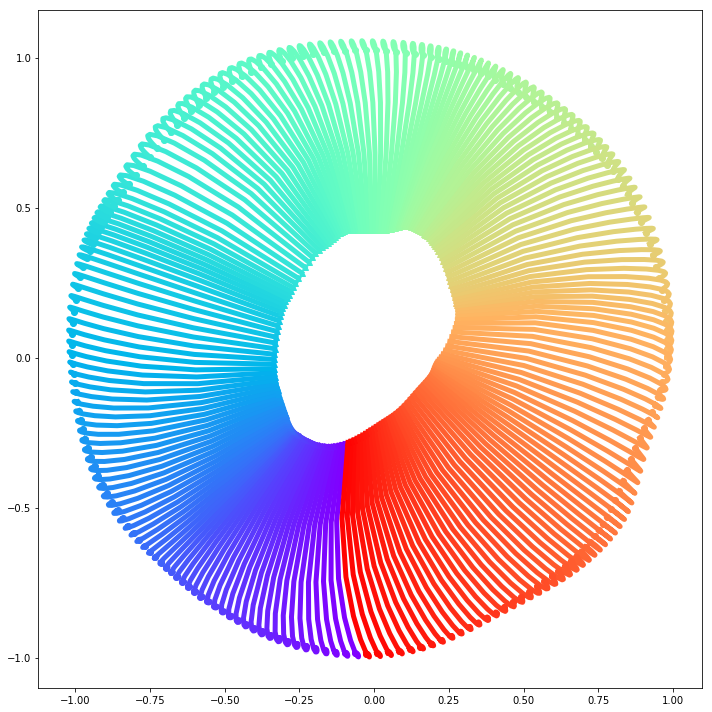

In [34]:
fig = plt.figure(figsize=(10, 10),tight_layout=True,facecolor='white')
X = onp.transpose(h_tf[trial.epochs['go1'][0]:,trial_set,:],(1,0,2))  # was trials x time x dim
D = params[2][:,1:3].T
plot_N(X, D)

nfps = len(h_t_all)

for fp in range(nfps):
    alpha = 0.05
    for fp in range(nfps):
        h_pca = np.dot(np.array(h_t_all[fp]),D.T)
        ax.plot3D(h_pca[:,0], 
                  h_pca[:,1],
                  h_pca[:,2], c=[1, 1, 1, alpha])    
        ax.plot3D(h_pca[0:1,0], 
                  h_pca[0:1,1],
                  h_pca[0:1,2], c = 'k', marker = 'o')    


    size = 100
    hstar_pca = pca.transform(sorted_fps)
    # color = onp.squeeze(onp.dot(params['wO'], sorted_fps.T) + onp.expand_dims(params['bO'], axis=1))
    # color = onp.where(color > 1.0, 1.0, color)
    # color = onp.where(color < -1.0, -1.0, color)
    # color = (color + 1.0) / 2.0    
    marker_style = dict(marker='*', s=size, edgecolor='gray')


    ax.scatter(hstar_pca[0:emax,0], hstar_pca[0:emax,1], hstar_pca[0:emax,2], 
               'k', **marker_style);#c=color[0:emax], **marker_style);

plt.title('High quality fixed points and the network dynamics initialized from them.');
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_zlabel('PC 3');


In [ ]:
def plot_FP(X, D, qvals, rdots, ldots):
    """Plot activity is some 2D space.

        Args:
            X: Fixed points in #Fps x Neurons
            D: Neurons x 2 plotting dims
    
        """
    log_qvals = np.log10(qvals)

    qmap=plt.get_cmap('gray')
    S = np.shape(X)[0]
    
    for s in range(S):
        c = 'k'
        X_trial = np.dot(X[s,:],D.T)
        plt.plot(X_trial[0],X_trial[1],'*',c = c)
        l = np.concatenate((X_trial - .01*ldots[s][1:], X_trial + .01*ldots[s][1:]),1)
        plt.plot(l[0:4:2],l[1:4:2],'y')
        r = np.concatenate((X_trial - .3*rdots[s][1:], X_trial + .3*rdots[s][1:]),1)
        plt.plot(r[0:4:2],r[1:4:2],'k')

fig = plt.figure(figsize=(10, 10),tight_layout=True,facecolor='white')

X = onp.transpose(h_tf[trial.epochs['go1'][0]:,trial_set,:],(1,0,2))  # was trials x time x dim
D = params[2][:,1:3].T
plot_N(X, D)

X = sorted_fps
D = params[2][:,1:3].T
plot_FP(X, D, fp_losses, rdots, ldots)
 
plt.xlabel('Readout Space 1')
plt.ylabel('Readout Space 2')     
plt.show()

In [39]:
np.shape(trial.stim_locs)

(1000, 4)

In [87]:
h_t = onp.array(h_t[:225,:])

TypeError: list indices must be integers, not tuple

In [41]:
fig = plt.figure(figsize=(15, 15),tight_layout=True,facecolor='white')

D = np.concatenate((np.expand_dims(Beta_stim1[:,0],axis=1),np.expand_dims(Beta_stim2[:,0],axis=1)),axis = 1)
D = np.concatenate((np.expand_dims(Beta_stim2[:,0],axis=1),np.expand_dims(Beta_stim2[:,1],axis=1)),axis = 1)


# inds_use = range(0,1000,50)
# X = onp.transpose(h_tf[trial.epochs['stim1'][0]:trial.epochs['stim2'][1],inds_use,:],(1, 0, 2))
# plot_N(X,D.T)

inds_use = range(4,1000,50)
X = onp.transpose(h_tf[trial.epochs['stim1'][0]-1:trial.epochs['stim2'][1],inds_use,:],(1, 0, 2))
plot_N(X,D.T)

X = sorted_fps
# plot_FP(X, D, fp_losses, rdots, ldots)

plt.xlabel('Beta_stim1 Space 1')
plt.ylabel('Beta_stim2 Space 1')
plt.title('Go Frame # ' + str(T1_use) + str(T2_use))  
plt.show()

NameError: name 'Beta_stim1' is not defined

<Figure size 1080x1080 with 0 Axes>

In [43]:
model = Model(model_dir)
with tf.Session() as sess:
    model.restore()
    hparams = model.hp
    trial = generate_trials(rule, hparams, mode='random', noise_on=False, batch_size = 1000, delay_fac =1)
    feed_dict = tools.gen_feed_dict(model, trial, hparams)
    h_tf, y_hat_tf = sess.run([model.h, model.y_hat], feed_dict=feed_dict) #(n_time, n_condition, n_neuron)

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /home/laura/data/rnn/multitask/stepnet/lowD/softplus/most/0/model.ckpt
Model restored from file: /home/laura/data/rnn/multitask/stepnet/lowD/softplus/most/0/model.ckpt


In [44]:
trial.epochs

{'delay1': (54, 89),
 'delay2': (109, 122),
 'fix1': (None, 28),
 'go1': (122, None),
 'stim1': (28, 54),
 'stim2': (89, 109)}

In [12]:
batch_size = 32
ntimesteps = 200#trial.epochs['stim2'][1]-trial.epochs['stim2'][0]
u = np.shape(h_tf)[0]
T,B,N = np.shape(h_tf)
h0 = h_tf[0,:,:].T

h_t_all = []#np.zeros((nfps,T,N))


x_t = trial.x[1:,:,:]
x = trial.x[trial.epochs['stim2'][0]+1,0,:]

for fp in range(1):
    h = h_tf[trial.epochs['stim2'][0],fp,:]
    h_t = []
    h_t.append(h)
    
    for i in range(ntimesteps-1):
        h = rnn_vanilla(params, np.squeeze(h), np.squeeze(x.T))
        h_t.append(np.expand_dims(h,axis=1))

    h_t_all.append(h_t)
    plt.plot(np.squeeze(h_t))
    plt.show()

KeyboardInterrupt: 

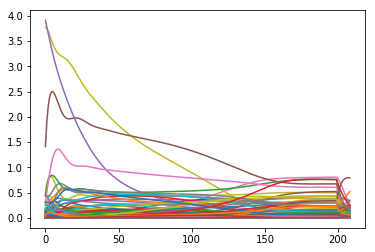

In [77]:
ntimesteps = trial.epochs['delay2'][1]-trial.epochs['delay2'][0]
x = trial.x[trial.epochs['delay2'][0]+1,0,:]

for i in range(ntimesteps-1):
    h = rnn_vanilla(params, np.squeeze(h), np.squeeze(x.T))
    h_t.append(np.expand_dims(h,axis=1))

plt.plot(np.squeeze(h_t))
plt.show()

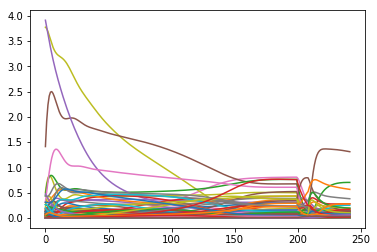

In [88]:
ntimesteps = np.shape(h_tf)[0]-trial.epochs['go1'][0]
x = trial.x[trial.epochs['go1'][0]+1,0,:]

for i in range(ntimesteps-1):
    h = rnn_vanilla(params, np.squeeze(h), np.squeeze(x.T))
    h_t.append(np.expand_dims(h,axis=1))

plt.plot(np.squeeze(h_t))
plt.show()

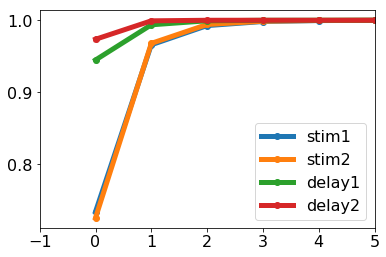

In [45]:
from sklearn.decomposition import PCA

for e in trial.epochs.keys()[:4]:
    h = h_tf[trial.epochs[e][0]:trial.epochs[e][1],:,:]
    pca = PCA(n_components=30).fit(np.reshape(h,(h.shape[0],-1)))
    plt.plot(onp.cumsum(pca.explained_variance_ratio_),'-o',linewidth = 5)
    plt.xlim((-1,5))

plt.legend(trial.epochs.keys()[:4])
plt.show()

In [46]:
# inds_use = onp.argsort(trial.stim_locs[:,0])[0:1000:10]
# inds_use = onp.argsort(trial.stim_strength[:,0])[0:1000:10]
# inds_use = onp.argsort(trial.y_loc[-1,:])[0:1000:10]


T1_use = trial.epochs['stim1'][1]
T2_use = trial.epochs['stim2'][1]

inds_use1 = trial.stim_strength[:,0]>1
stim1 = trial.stim_locs[inds_use1,0:1]
X = h_tf[T1_use,inds_use1,:].T
y1 = np.sin(stim1)
y2 = np.cos(stim1)
y = onp.concatenate((y1,y2),axis=1)

X_zscore = stats.zscore(X, axis=1)
X_zscore_nonan = X_zscore
X_zscore_nonan[np.isnan(X_zscore)] = 0
r = X_zscore_nonan

lm = linear_model.LinearRegression()
model = lm.fit(y,r.T)
Beta = model.coef_
Beta_stim1,_ = LA.qr(Beta)


inds_use2 = trial.stim_strength[:,1]>1
stim2 = trial.stim_locs[inds_use2,1:2]
X = h_tf[T2_use,inds_use2,:].T
y1 = np.sin(stim2)
y2 = np.cos(stim2)
y = onp.concatenate((y1,y2),axis=1)

X_zscore = stats.zscore(X, axis=1)
X_zscore_nonan = X_zscore
X_zscore_nonan[np.isnan(X_zscore)] = 0
r = X_zscore_nonan

lm = linear_model.LinearRegression()
model = lm.fit(y,r.T)
Beta = model.coef_
Beta_stim2,_ = LA.qr(Beta)


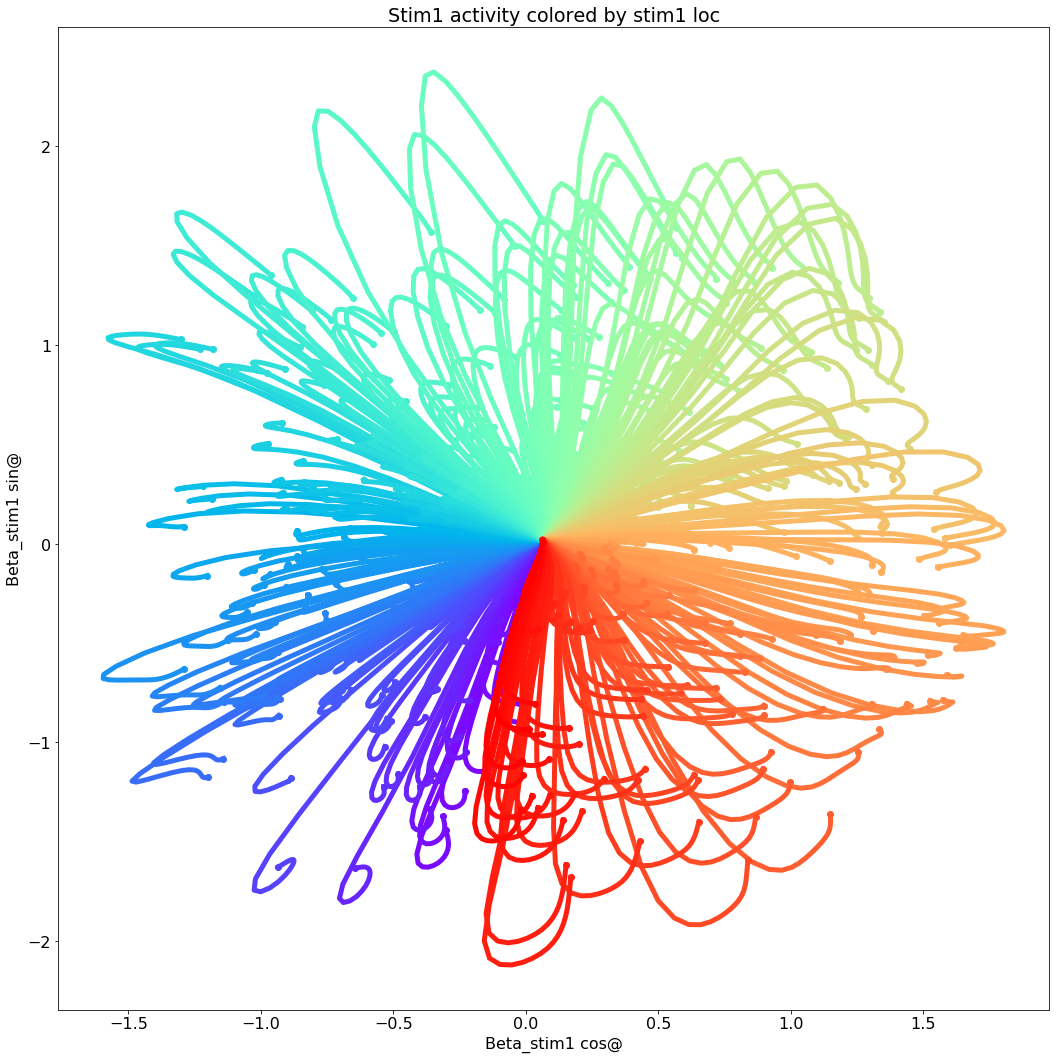

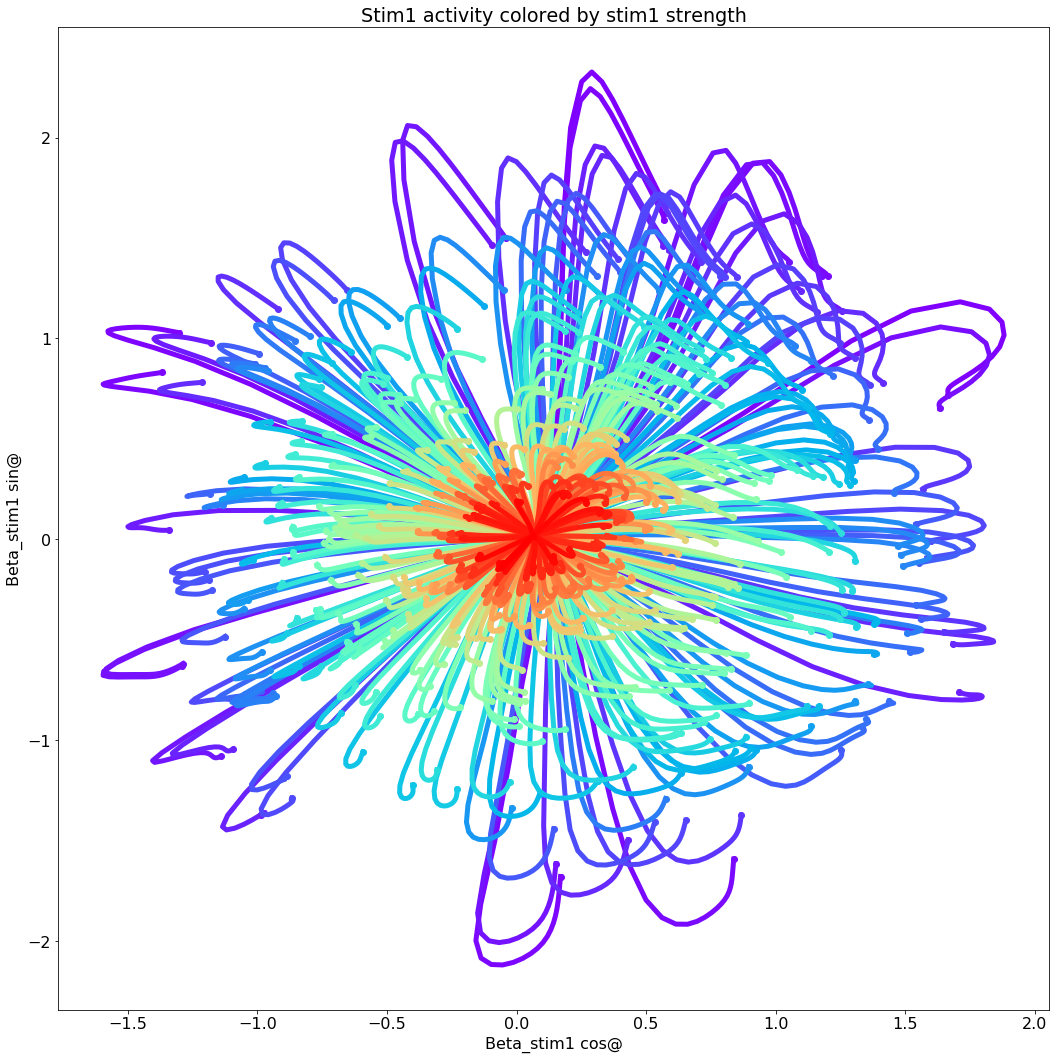

In [54]:
fig = plt.figure(figsize=(15, 15),tight_layout=True,facecolor='white')
plt.rcParams.update({'font.size': 16})

inds_use = onp.argsort(trial.stim_locs[:,0])[0:1000:2]#range(0,1000,50)#
D = np.concatenate((np.expand_dims(Beta_stim1[:,0],axis=1),np.expand_dims(Beta_stim1[:,1],axis=1)),axis = 1)
X = onp.transpose(h_tf[trial.epochs['stim1'][0]-1:trial.epochs['stim1'][1],inds_use,:],(1, 0, 2))
plot_N(X,D.T)

plt.xlabel('Beta_stim1 cos@')
plt.ylabel('Beta_stim1 sin@')
plt.title('Stim1 activity colored by stim1 loc')  
plt.show()

fig = plt.figure(figsize=(15, 15),tight_layout=True,facecolor='white')
plt.rcParams.update({'font.size': 16})

inds_use = onp.argsort(trial.stim_strength[:,0])[0:1000:2]#range(0,1000,50)#
D = np.concatenate((np.expand_dims(Beta_stim1[:,0],axis=1),np.expand_dims(Beta_stim1[:,1],axis=1)),axis = 1)
X = onp.transpose(h_tf[trial.epochs['stim1'][0]-1:trial.epochs['stim1'][1],inds_use[-1:0:-1],:],(1, 0, 2))
plot_N(X,D.T)

plt.xlabel('Beta_stim1 cos@')
plt.ylabel('Beta_stim1 sin@')
plt.title('Stim1 activity colored by stim1 strength')  
plt.show()


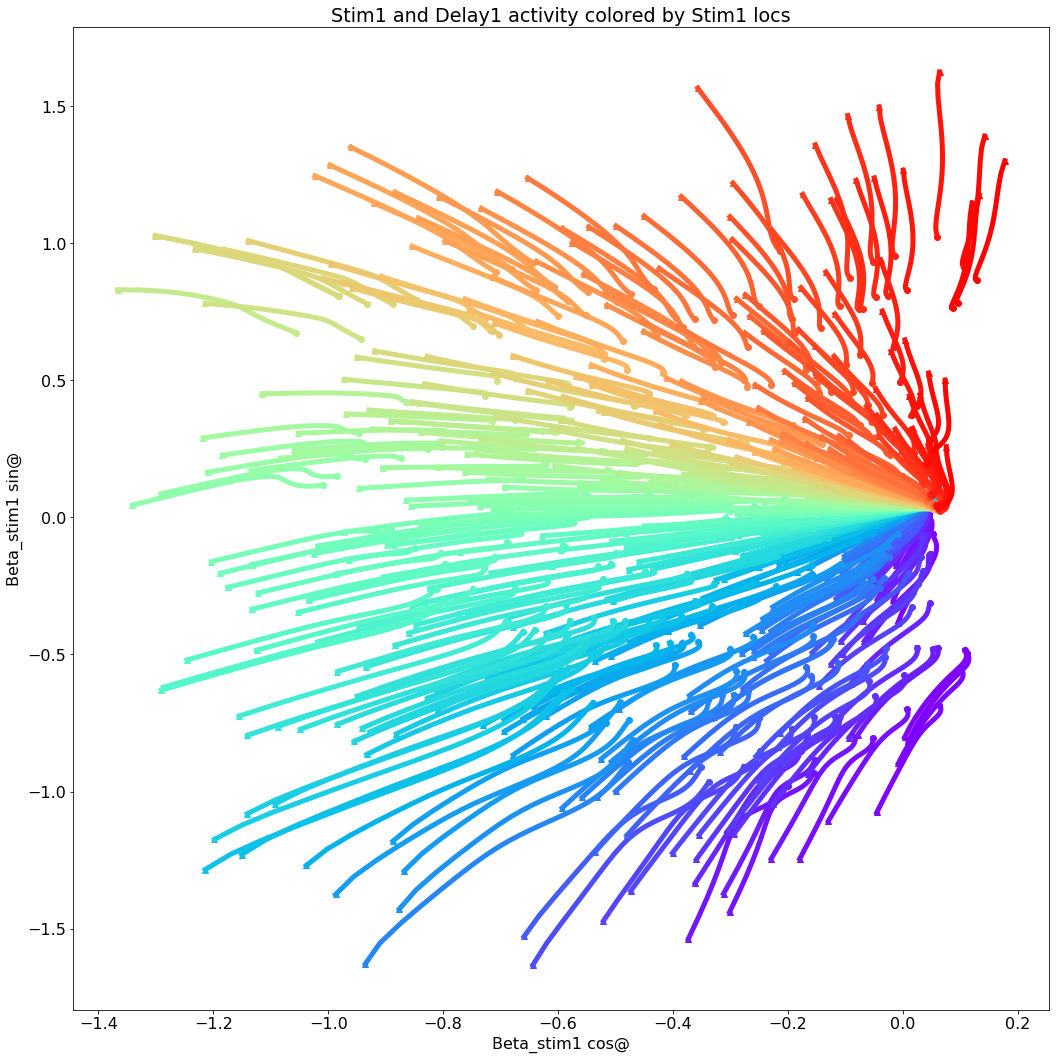

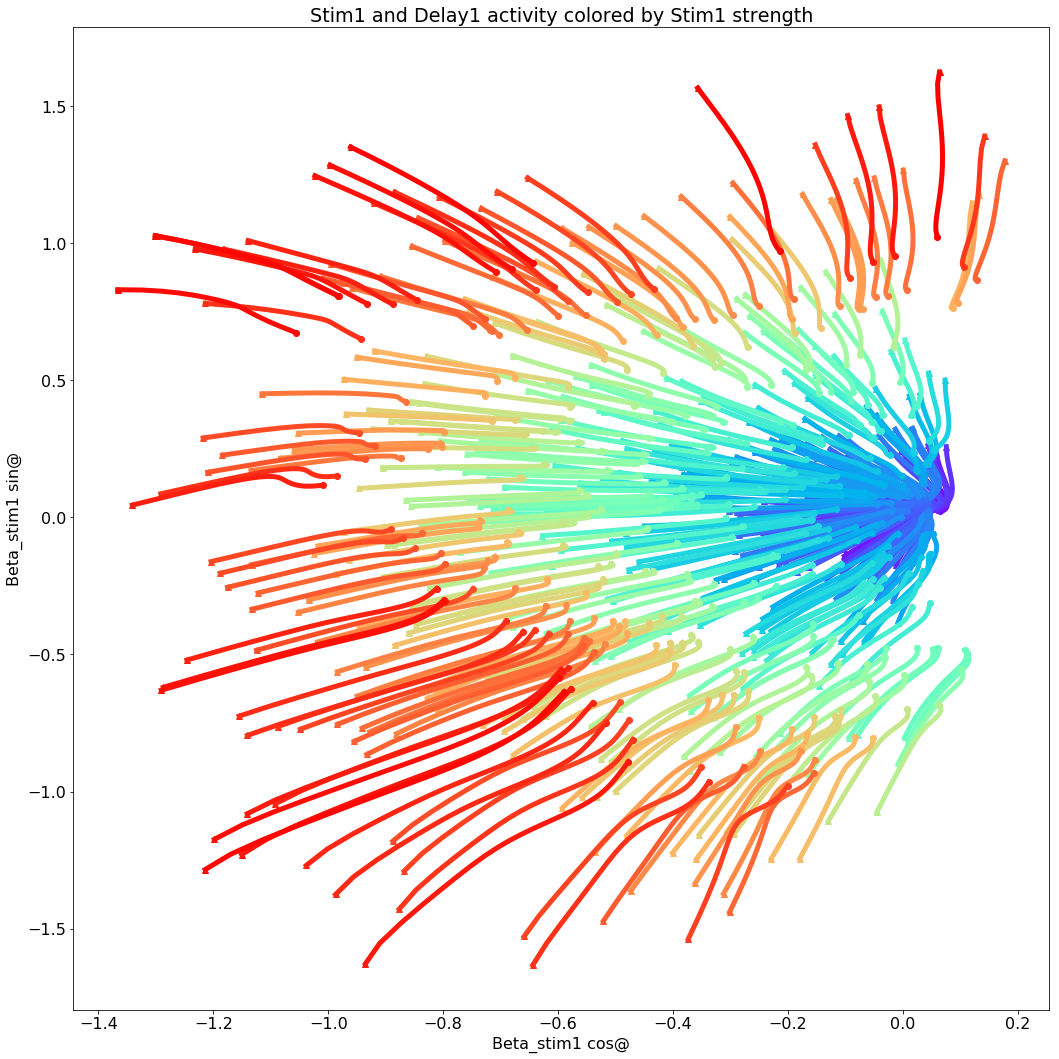

In [55]:
fig = plt.figure(figsize=(15, 15),tight_layout=True,facecolor='white')

inds_use = onp.argsort(trial.stim_locs[:,0])#range(0,1000,50)#
inds_use = inds_use[trial.stim_locs[:,0][inds_use]<np.pi]
D = np.concatenate((np.expand_dims(Beta_stim1[:,0],axis=1),np.expand_dims(Beta_stim1[:,1],axis=1)),axis = 1)
X = onp.transpose(h_tf[trial.epochs['delay1'][0]-1:trial.epochs['delay1'][1],inds_use,:],(1, 0, 2))
plot_N(X,D.T)
plt.xlabel('Beta_stim1 cos@')
plt.ylabel('Beta_stim1 sin@')
plt.title('Stim1 and Delay1 activity colored by Stim1 locs')  
plt.show()

fig = plt.figure(figsize=(15, 15),tight_layout=True,facecolor='white')

inds_use = onp.argsort(trial.stim_strength[:,0])#range(0,1000,50)#
inds_use = inds_use[trial.stim_locs[:,0][inds_use]<np.pi]
D = np.concatenate((np.expand_dims(Beta_stim1[:,0],axis=1),np.expand_dims(Beta_stim1[:,1],axis=1)),axis = 1)
X = onp.transpose(h_tf[trial.epochs['delay1'][0]-1:trial.epochs['delay1'][1],inds_use,:],(1, 0, 2))
plot_N(X,D.T)
plt.xlabel('Beta_stim1 cos@')
plt.ylabel('Beta_stim1 sin@')
plt.title('Stim1 and Delay1 activity colored by Stim1 strength')  
plt.show()

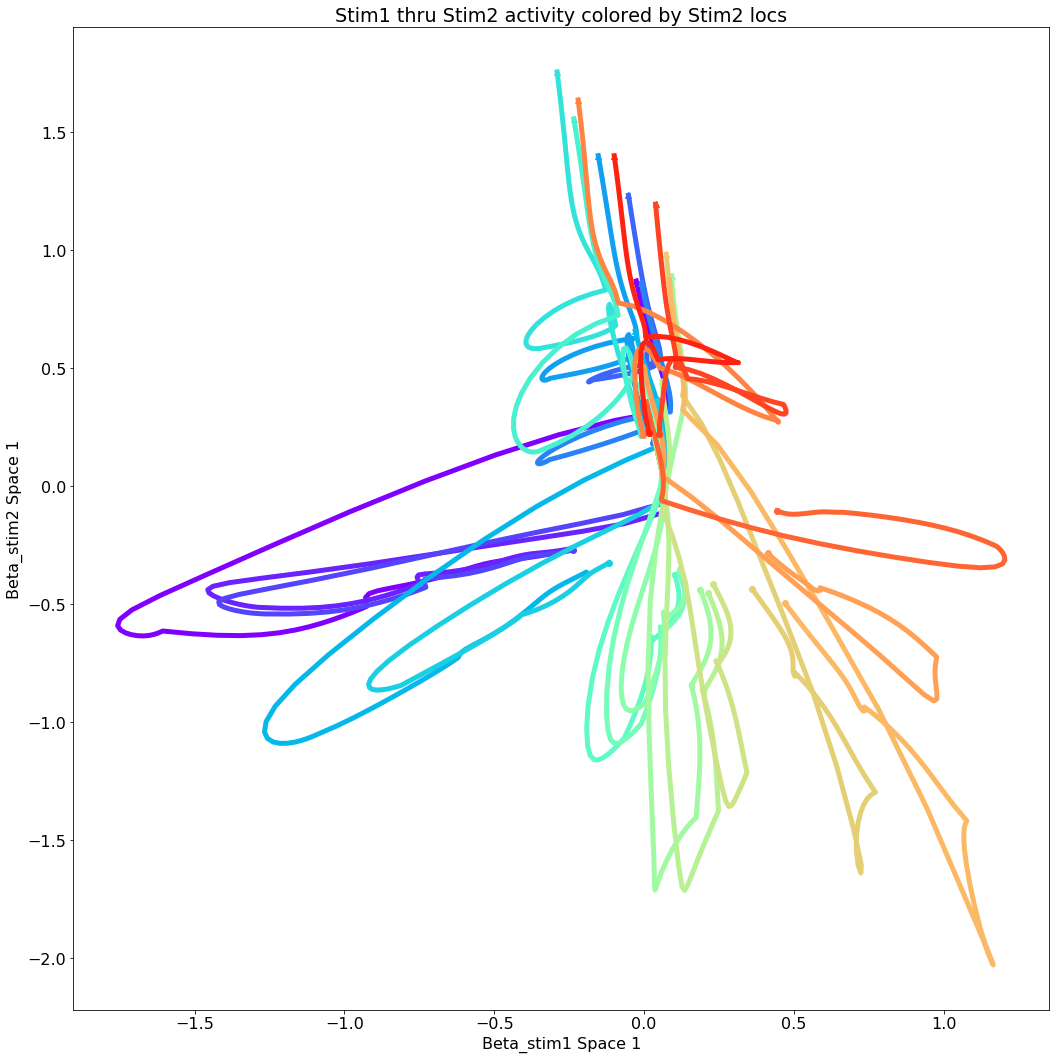

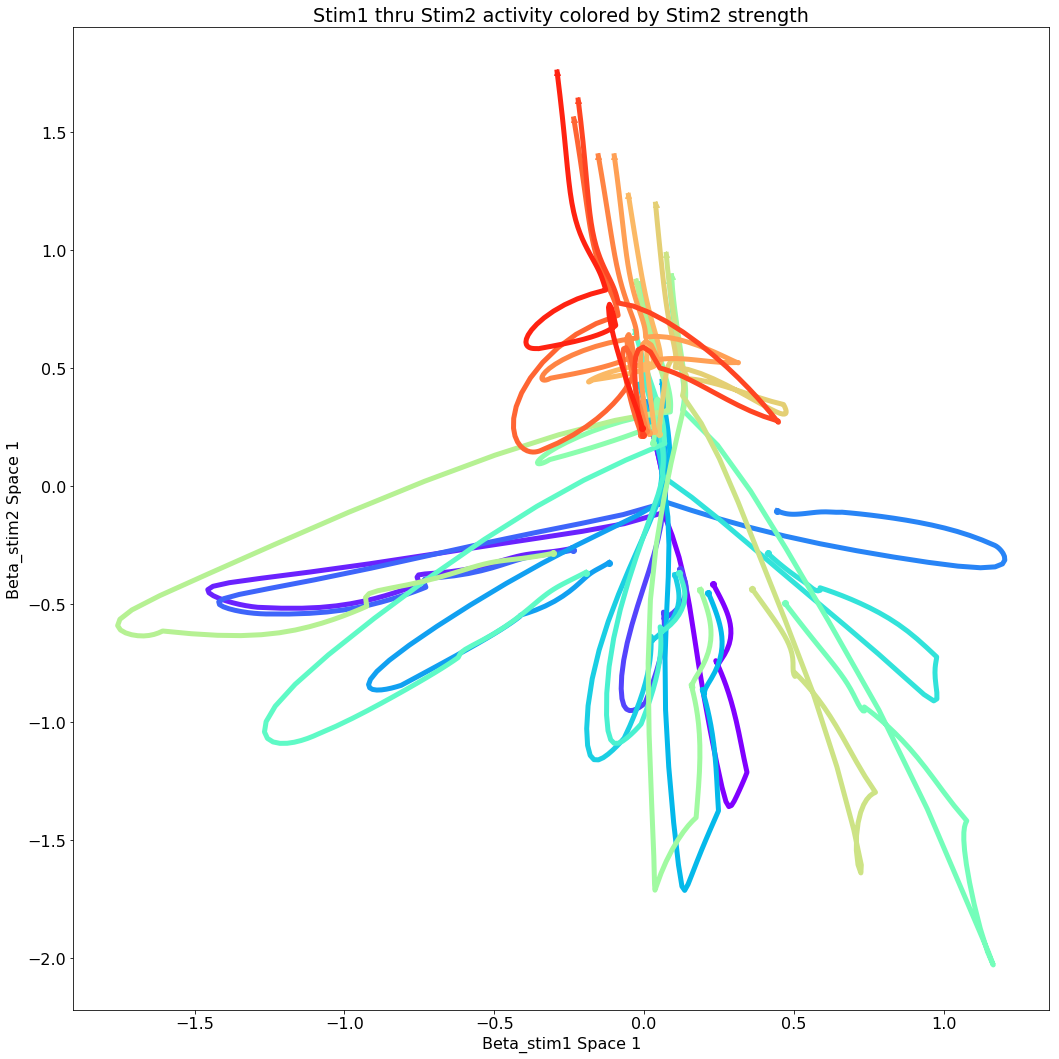

In [62]:
fig = plt.figure(figsize=(15, 15),tight_layout=True,facecolor='white')

inds_use = onp.argsort(trial.stim_locs[:,1])#range(0,1000,50)#
inds_use = inds_use[trial.stim_locs[:,0][inds_use]<np.pi/16]
D = np.concatenate((np.expand_dims(Beta_stim2[:,0],axis=1),np.expand_dims(Beta_stim2[:,1],axis=1)),axis = 1)
X = onp.transpose(h_tf[trial.epochs['delay1'][0]-1:trial.epochs['go1'][1],inds_use,:],(1, 0, 2))
plot_N(X,D.T)
plt.xlabel('Beta_stim2 Space 1')
plt.ylabel('Beta_stim2 Space 2')
plt.title('Stim1 thru Stim2 activity colored by Stim2 locs')  
plt.show()

fig = plt.figure(figsize=(15, 15),tight_layout=True,facecolor='white')

inds_use = onp.argsort(trial.stim_strength[:,0])#range(0,1000,50)#
inds_use = inds_use[trial.stim_locs[:,0][inds_use]<np.pi/16]
D = np.concatenate((np.expand_dims(Beta_stim2[:,0],axis=1),np.expand_dims(Beta_stim2[:,1],axis=1)),axis = 1)
X = onp.transpose(h_tf[trial.epochs['delay1'][0]-1:trial.epochs['go1'][1],inds_use,:],(1, 0, 2))
plot_N(X,D.T)
plt.xlabel('Beta_stim2 Space 1')
plt.ylabel('Beta_stim2 Space 2')
plt.title('Stim1 thru Stim2 activity colored by Stim2 strength')  
plt.show()

In [50]:
# inds_use = onp.argsort(trial.stim_locs[:,0])[0:1000:10]
# inds_use = onp.argsort(trial.stim_strength[:,0])[0:1000:10]
# inds_use = onp.argsort(trial.y_loc[-1,:])[0:1000:10]

T1_use = trial.epochs['delay1'][1]
T2_use = trial.epochs['delay2'][1]

inds_use1 = trial.stim_strength[:,0]>1
stim1 = trial.stim_locs[inds_use1,0:1]
X = h_tf[T1_use,inds_use1,:].T
y1 = np.sin(stim1)
y2 = np.cos(stim1)
y = onp.concatenate((y1,y2),axis=1)

X_zscore = stats.zscore(X, axis=1)
X_zscore_nonan = X_zscore
X_zscore_nonan[np.isnan(X_zscore)] = 0
r = X_zscore_nonan

lm = linear_model.LinearRegression()
model = lm.fit(y,r.T)
Beta = model.coef_
Beta_delay1,_ = LA.qr(Beta)

inds_use2 = trial.stim_strength[:,1]>1
stim2 = trial.stim_locs[inds_use2,1:2]
X = h_tf[T2_use,inds_use2,:].T
y1 = np.sin(stim2)
y2 = np.cos(stim2)
y = onp.concatenate((y1,y2),axis=1)

X_zscore = stats.zscore(X, axis=1)
X_zscore_nonan = X_zscore
X_zscore_nonan[np.isnan(X_zscore)] = 0
r = X_zscore_nonan

lm = linear_model.LinearRegression()
model = lm.fit(y,r.T)
Beta = model.coef_
Beta_delay2,_ = LA.qr(Beta)


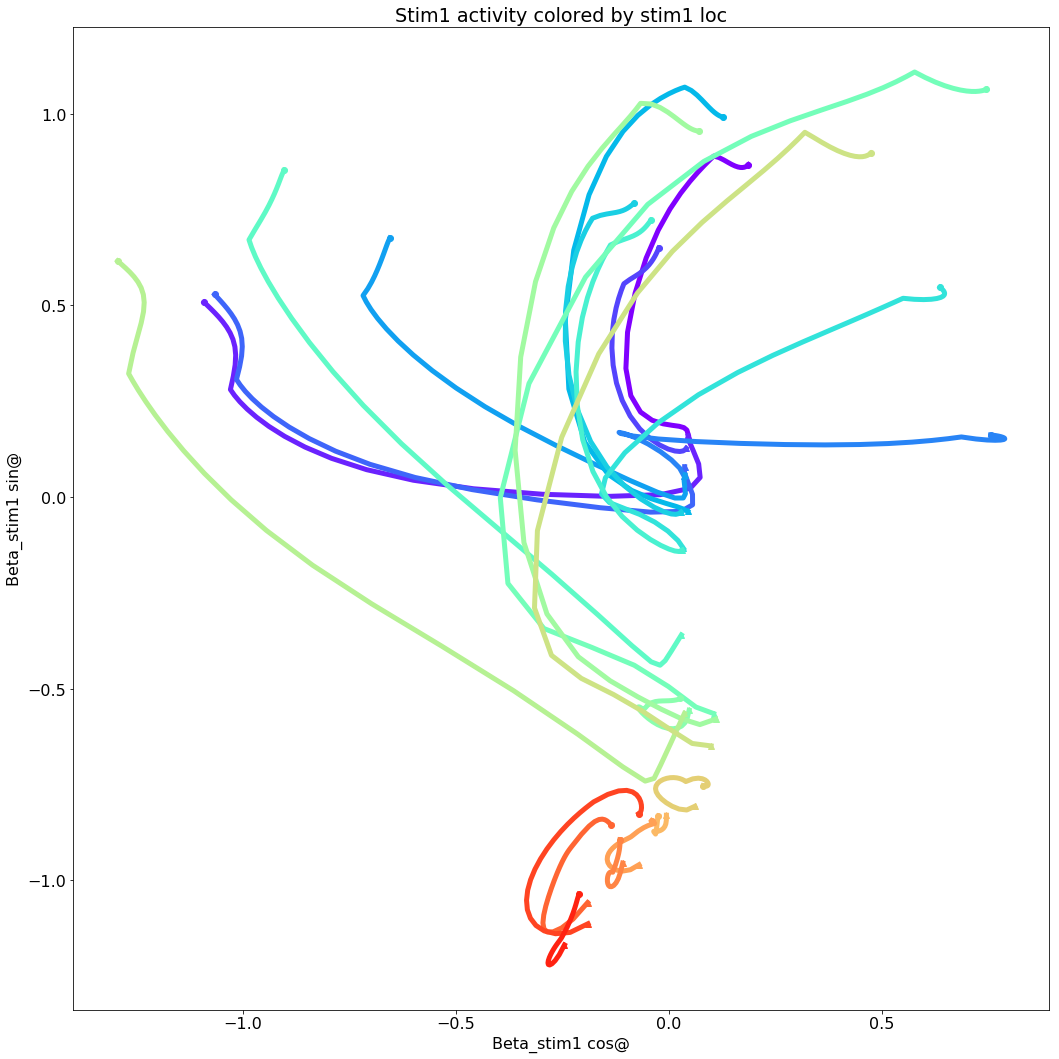

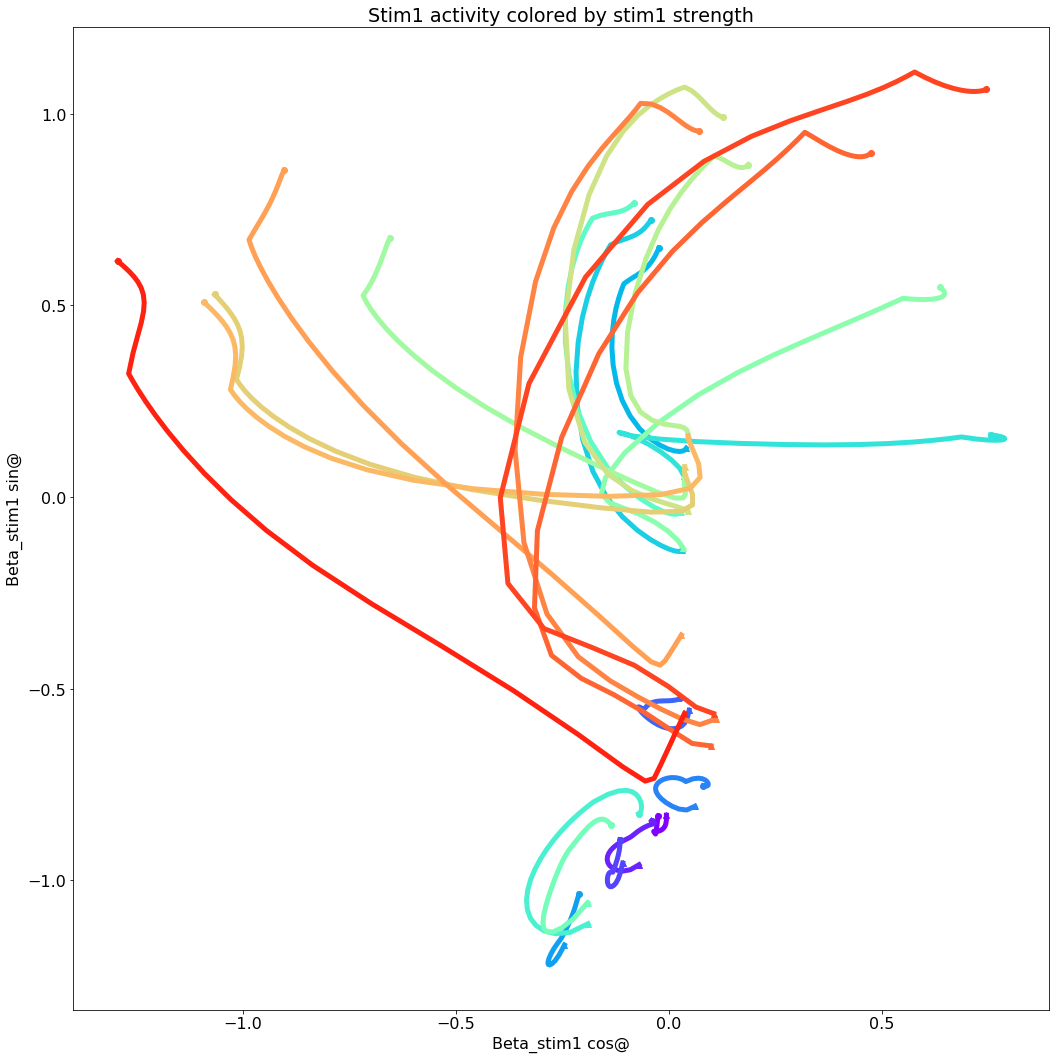

In [72]:
fig = plt.figure(figsize=(15, 15),tight_layout=True,facecolor='white')
plt.rcParams.update({'font.size': 16})

inds_use = onp.argsort(trial.stim_strength[:,0])#range(0,1000,50)#
inds_use = inds_use[trial.stim_locs[:,0][inds_use]<np.pi/16]
D = np.concatenate((np.expand_dims(Beta_delay2[:,0],axis=1),np.expand_dims(Beta_delay2[:,1],axis=1)),axis = 1)
X = onp.transpose(h_tf[trial.epochs['stim2'][0]-1:trial.epochs['delay2'][1],inds_use,:],(1, 0, 2))
plot_N(X,D.T)

plt.xlabel('Beta_delay2 cos@')
plt.ylabel('Beta_delay2 sin@')
plt.title('Stim1 activity colored by stim1 loc')  
plt.show()

fig = plt.figure(figsize=(15, 15),tight_layout=True,facecolor='white')
plt.rcParams.update({'font.size': 16})

inds_use = onp.argsort(trial.stim_strength[:,1])#range(0,1000,50)#
inds_use = inds_use[trial.stim_locs[:,0][inds_use]<np.pi/16]
D = np.concatenate((np.expand_dims(Beta_delay2[:,0],axis=1),np.expand_dims(Beta_delay2[:,1],axis=1)),axis = 1)
X = onp.transpose(h_tf[trial.epochs['stim2'][0]-1:trial.epochs['delay2'][1],inds_use,:],(1, 0, 2))
plot_N(X,D.T)

plt.xlabel('Beta_delay2 cos@')
plt.ylabel('Beta_delay2 sin@')
plt.title('Stim1 activity colored by stim1 strength')  
plt.show()


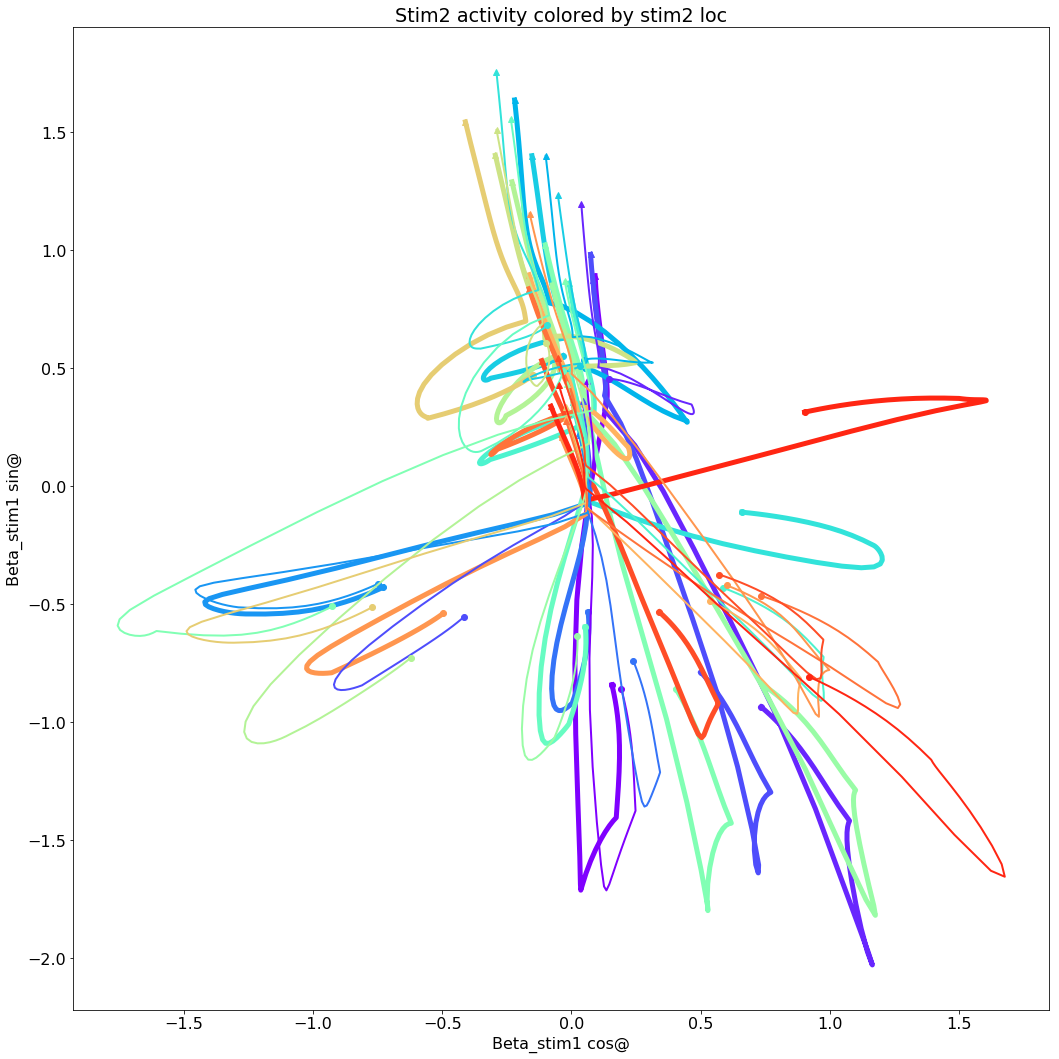

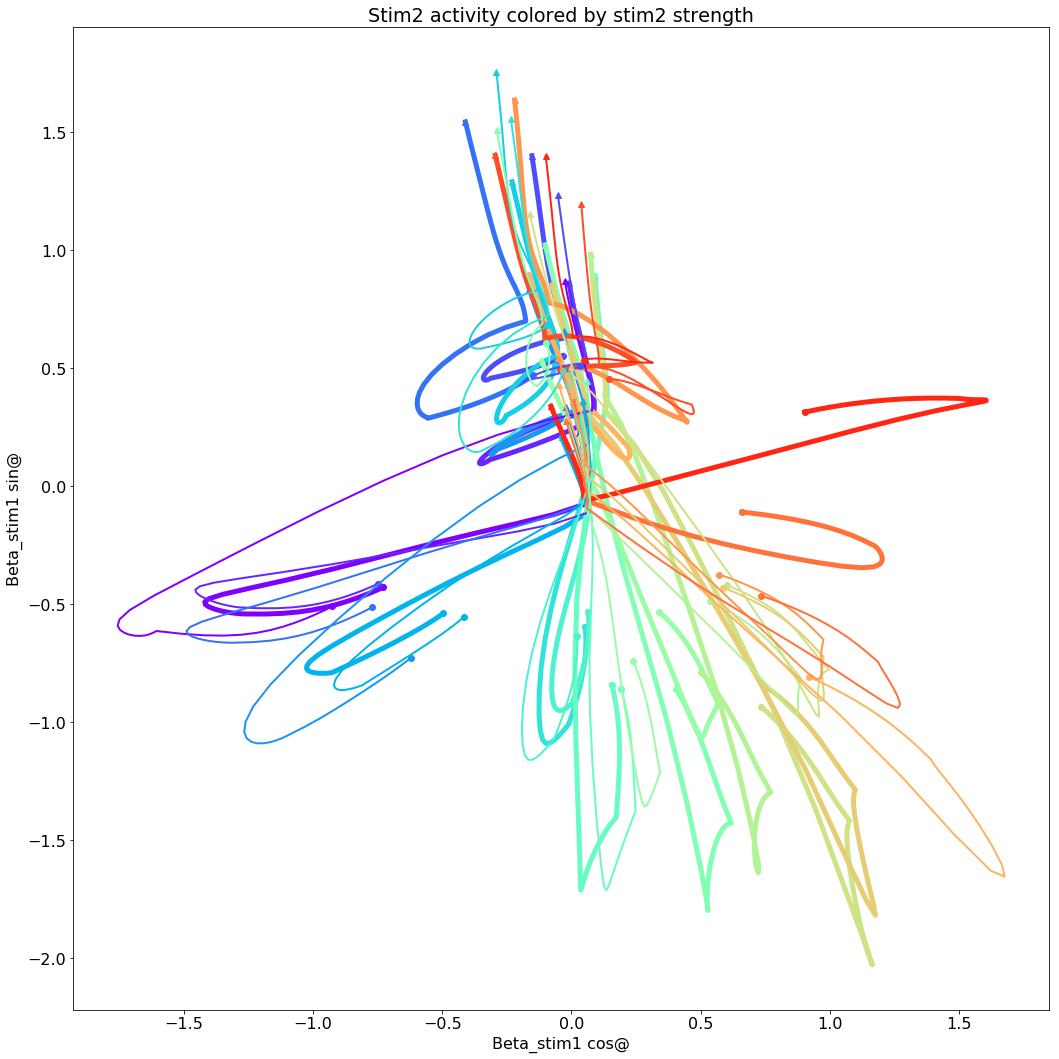

In [52]:
fig = plt.figure(figsize=(15, 15),tight_layout=True,facecolor='white')
plt.rcParams.update({'font.size': 16})

inds_use1 = onp.argsort(trial.stim_locs[:,0])#range(0,1000,50)#
inds_use1 = inds_use1[trial.stim_strength[:,0]<trial.stim_strength[:,1]]
inds_use1 = inds_use1[:20:1]
D = np.concatenate((np.expand_dims(Beta_stim2[:,0],axis=1),np.expand_dims(Beta_stim2[:,1],axis=1)),axis = 1)
X = onp.transpose(h_tf[trial.epochs['delay1'][0]-1:trial.epochs['delay2'][1],inds_use1,:],(1, 0, 2))
plot_N(X,D.T)

inds_use2 = onp.argsort(trial.stim_locs[:,0])#range(0,1000,50)#
inds_use2 = inds_use2[trial.stim_strength[:,0]>trial.stim_strength[:,1]]
inds_use2 = inds_use2[:20:1]
D = np.concatenate((np.expand_dims(Beta_stim2[:,0],axis=1),np.expand_dims(Beta_stim2[:,1],axis=1)),axis = 1)
X = onp.transpose(h_tf[trial.epochs['delay1'][0]-1:trial.epochs['delay2'][1],inds_use2,:],(1, 0, 2))
plot_N(X,D.T,linewidth=2)

plt.xlabel('Beta_stim1 cos@')
plt.ylabel('Beta_stim1 sin@')
plt.title('Stim2 activity colored by stim2 loc')  
plt.show()

fig = plt.figure(figsize=(15, 15),tight_layout=True,facecolor='white')
plt.rcParams.update({'font.size': 16})

i = onp.argsort(trial.stim_locs[inds_use1,1])#range(0,1000,50)#
inds_use1 = inds_use1[i]
D = np.concatenate((np.expand_dims(Beta_stim2[:,0],axis=1),np.expand_dims(Beta_stim2[:,1],axis=1)),axis = 1)
X = onp.transpose(h_tf[trial.epochs['delay1'][0]-1:trial.epochs['delay2'][1],inds_use1,:],(1, 0, 2))
plot_N(X,D.T)

i = onp.argsort(trial.stim_locs[inds_use2,1])#range(0,1000,50)#
inds_use2 = inds_use2[i]
D = np.concatenate((np.expand_dims(Beta_stim2[:,0],axis=1),np.expand_dims(Beta_stim2[:,1],axis=1)),axis = 1)
X = onp.transpose(h_tf[trial.epochs['delay1'][0]-1:trial.epochs['delay2'][1],inds_use2,:],(1, 0, 2))
plot_N(X,D.T,linewidth=2)

plt.xlabel('Beta_stim1 cos@')
plt.ylabel('Beta_stim1 sin@')
plt.title('Stim2 activity colored by stim2 strength')  
plt.show()


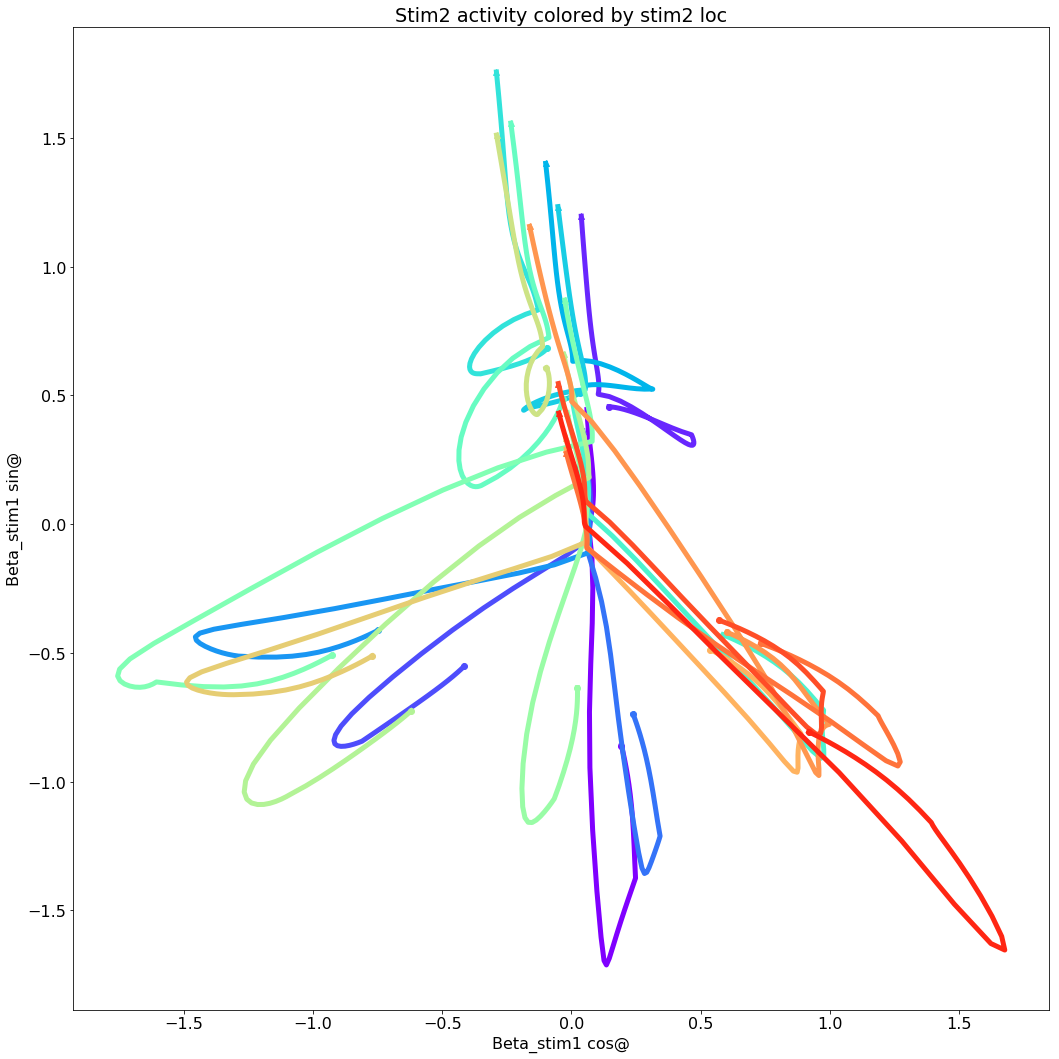

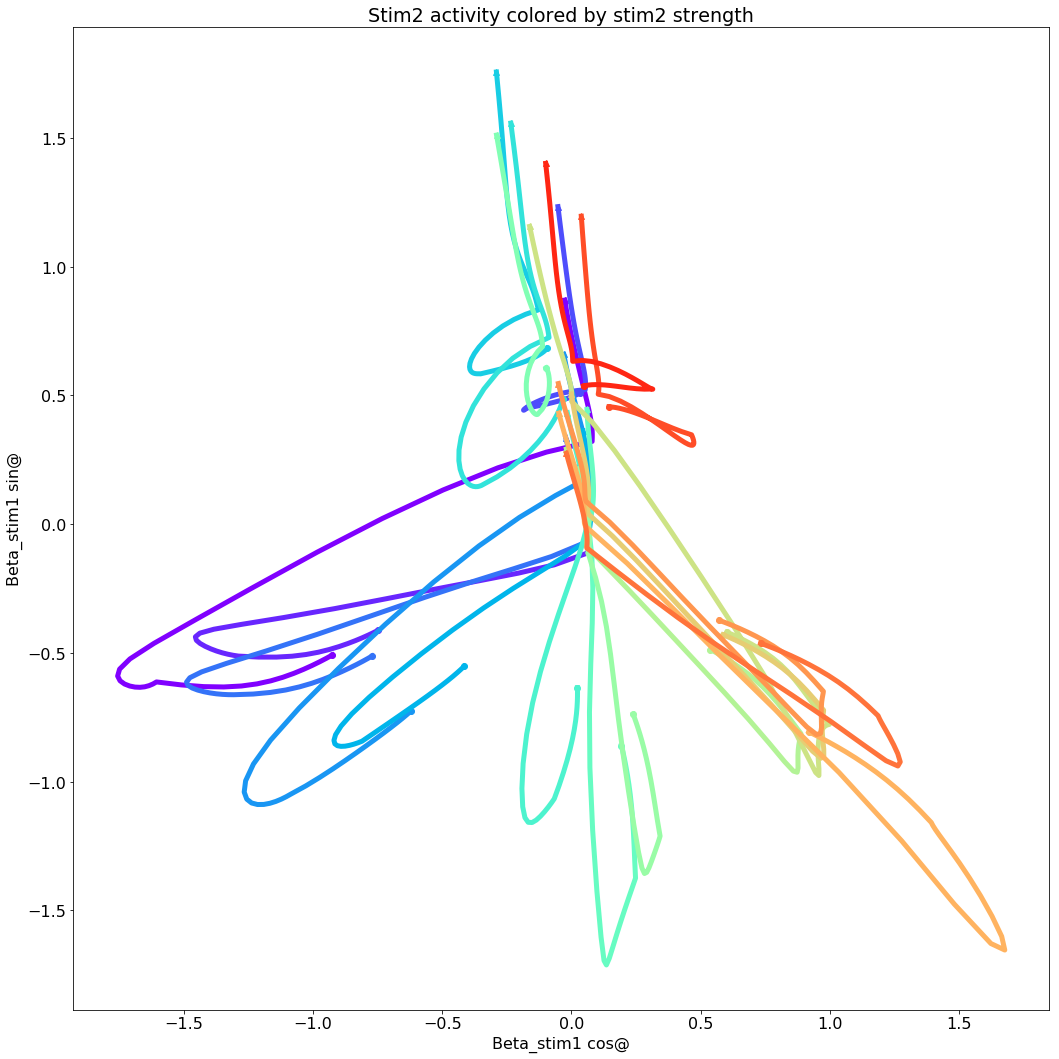

In [53]:
fig = plt.figure(figsize=(15, 15),tight_layout=True,facecolor='white')
plt.rcParams.update({'font.size': 16})

inds_use = onp.argsort(trial.stim_locs[:,0])#range(0,1000,50)#
inds_use = inds_use[trial.stim_strength[:,0]>trial.stim_strength[:,1]]
inds_use = inds_use[:20:1]
D = np.concatenate((np.expand_dims(Beta_stim2[:,0],axis=1),np.expand_dims(Beta_stim2[:,1],axis=1)),axis = 1)
X = onp.transpose(h_tf[trial.epochs['delay1'][0]-1:trial.epochs['delay2'][1],inds_use,:],(1, 0, 2))
plot_N(X,D.T)

plt.xlabel('Beta_stim1 cos@')
plt.ylabel('Beta_stim1 sin@')
plt.title('Stim2 activity colored by stim2 loc')  
plt.show()

fig = plt.figure(figsize=(15, 15),tight_layout=True,facecolor='white')
plt.rcParams.update({'font.size': 16})

i = onp.argsort(trial.stim_locs[inds_use,1])#range(0,1000,50)#
inds_use = inds_use[i]
D = np.concatenate((np.expand_dims(Beta_stim2[:,0],axis=1),np.expand_dims(Beta_stim2[:,1],axis=1)),axis = 1)
X = onp.transpose(h_tf[trial.epochs['delay1'][0]-1:trial.epochs['delay2'][1],inds_use,:],(1, 0, 2))
plot_N(X,D.T)

plt.xlabel('Beta_stim1 cos@')
plt.ylabel('Beta_stim1 sin@')
plt.title('Stim2 activity colored by stim2 strength')  
plt.show()

In [80]:
print(trial.stim_locs[inds_use,:2])

[[0.15068078 1.8771114 ]
 [0.08286421 1.92420381]
 [0.29318511 1.92508083]
 [0.09411796 1.96679648]
 [0.27451718 1.9820117 ]
 [0.20369716 1.98275388]
 [0.24307489 2.11015375]
 [0.404469   2.11171445]
 [0.24650703 2.18512329]
 [0.18014698 2.23330252]
 [0.04753764 2.29421755]
 [0.49027106 2.40433631]
 [0.12618703 2.45512287]
 [0.86066836 2.48704546]
 [0.25695028 2.50027679]
 [0.27872997 2.55304656]
 [0.46910795 2.65356405]
 [0.60803149 2.67621818]
 [0.14396131 2.68936461]
 [0.38551088 2.76536303]
 [1.08050201 2.76569109]
 [0.71458092 2.78256343]
 [0.97478835 2.7850048 ]
 [0.88980536 2.82082548]
 [1.00471268 2.87113236]
 [0.51250997 2.89131577]
 [0.26179403 2.89256606]
 [0.17369869 2.92769815]
 [0.58469837 2.9650776 ]
 [0.5319216  3.0030756 ]
 [1.08894826 3.02946427]
 [0.28360848 3.05979053]
 [1.09880022 3.11016263]
 [0.0231454  3.16336031]
 [0.20313015 3.24653356]
 [0.08038766 3.26360817]
 [0.56714731 3.28333975]
 [0.67076096 3.32438096]
 [0.9492576  3.37656183]
 [0.32863598 3.44936936]


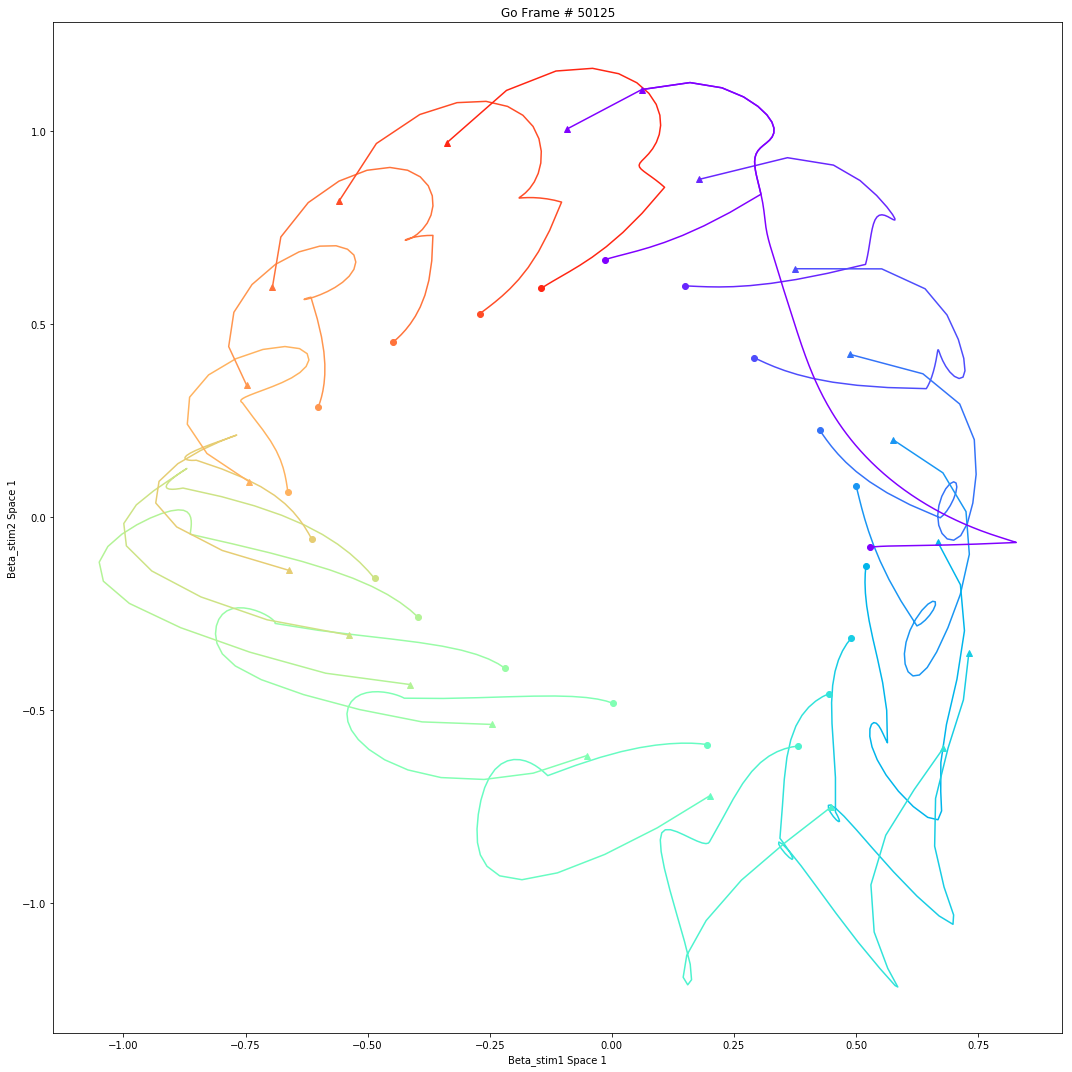

In [79]:
fig = plt.figure(figsize=(15, 15),tight_layout=True,facecolor='white')

# inds_use = range(0,1000,5)
# t_inds = range(trial.epochs['stim1'][0],trial.epochs['stim2'][1])
# D = np.concatenate((np.expand_dims(Beta_stim2[:,0],axis=1),np.expand_dims(Beta_stim2[:,1],axis=1)),axis = 1)
# X = onp.transpose(h_tf[trial.epochs['stim1'][0]:trial.epochs['stim2'][1],inds_use,:],(1, 0, 2))
# plot_N(X,D.T)

inds_use = range(0,1000,50)#onp.argsort(trial.stim_locs[:,0])[0:1000:5]
D = np.concatenate((np.expand_dims(Beta_stim1[:,0],axis=1),np.expand_dims(Beta_stim1[:,1],axis=1)),axis = 1)
X = onp.transpose(h_tf[trial.epochs['stim2'][0]-1:trial.epochs['delay2'][1],inds_use,:],(1, 0, 2))
plot_N(X,D.T)

X = onp.expand_dims(h_t,axis = 0)
plot_N(X,D.T)

plt.xlabel('Beta_stim1 Space 1')
plt.ylabel('Beta_stim2 Space 1')
plt.title('Go Frame # ' + str(T1_use) + str(T2_use))  
plt.show()

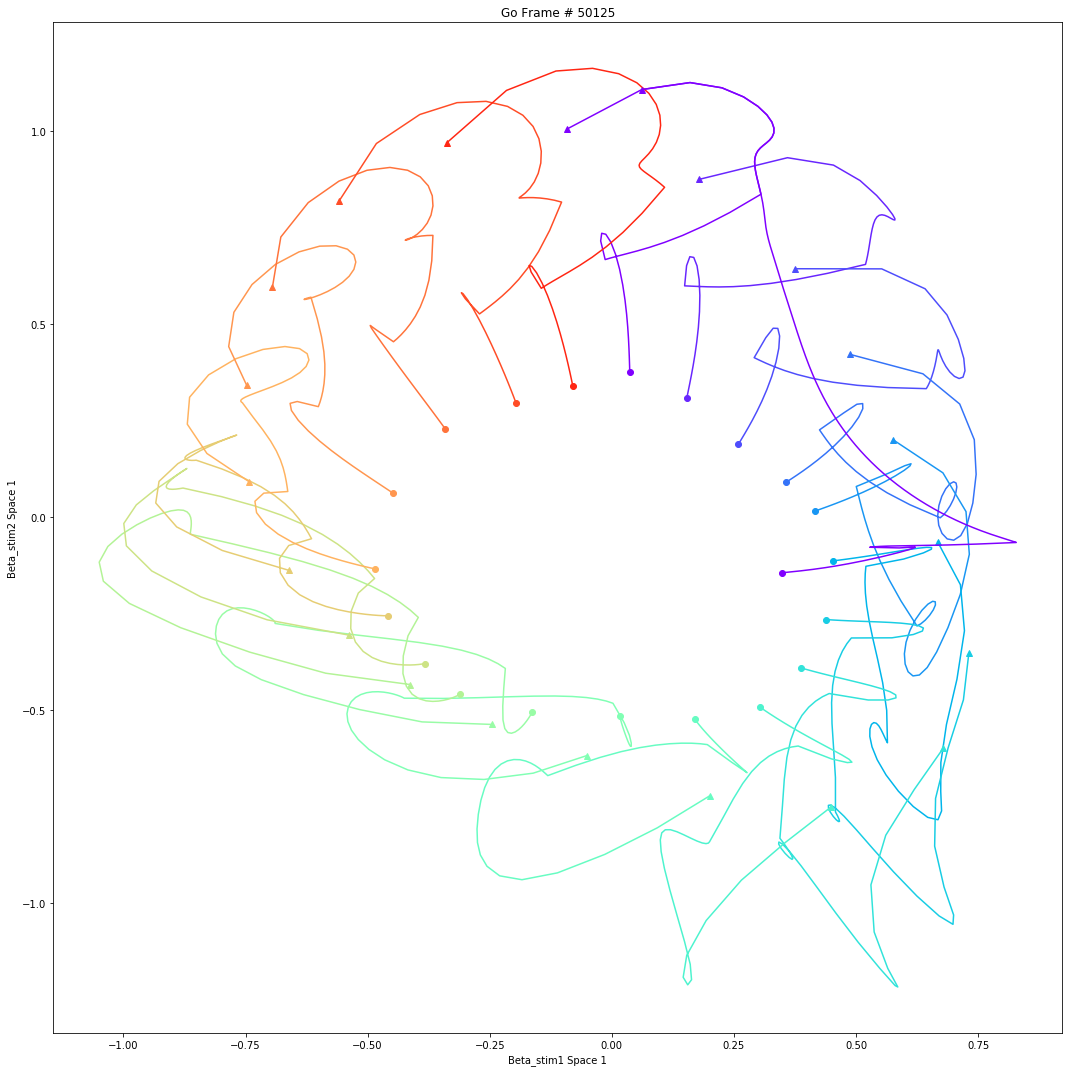

In [89]:
fig = plt.figure(figsize=(15, 15),tight_layout=True,facecolor='white')

# inds_use = range(0,1000,5)
# t_inds = range(trial.epochs['stim1'][0],trial.epochs['stim2'][1])
# D = np.concatenate((np.expand_dims(Beta_stim2[:,0],axis=1),np.expand_dims(Beta_stim2[:,1],axis=1)),axis = 1)
# X = onp.transpose(h_tf[trial.epochs['stim1'][0]:trial.epochs['stim2'][1],inds_use,:],(1, 0, 2))
# plot_N(X,D.T)

inds_use = range(0,1000,50)#onp.argsort(trial.stim_locs[:,0])[0:1000:5]
D = np.concatenate((np.expand_dims(Beta_stim1[:,0],axis=1),np.expand_dims(Beta_stim1[:,1],axis=1)),axis = 1)
X = onp.transpose(h_tf[trial.epochs['stim2'][0]-1:trial.epochs['go1'][1],inds_use,:],(1, 0, 2))
plot_N(X,D.T)

X = onp.expand_dims(h_t,axis = 0)
plot_N(X,D.T)

plt.xlabel('Beta_stim1 Space 1')
plt.ylabel('Beta_stim2 Space 1')
plt.title('Go Frame # ' + str(T1_use) + str(T2_use))  
plt.show()

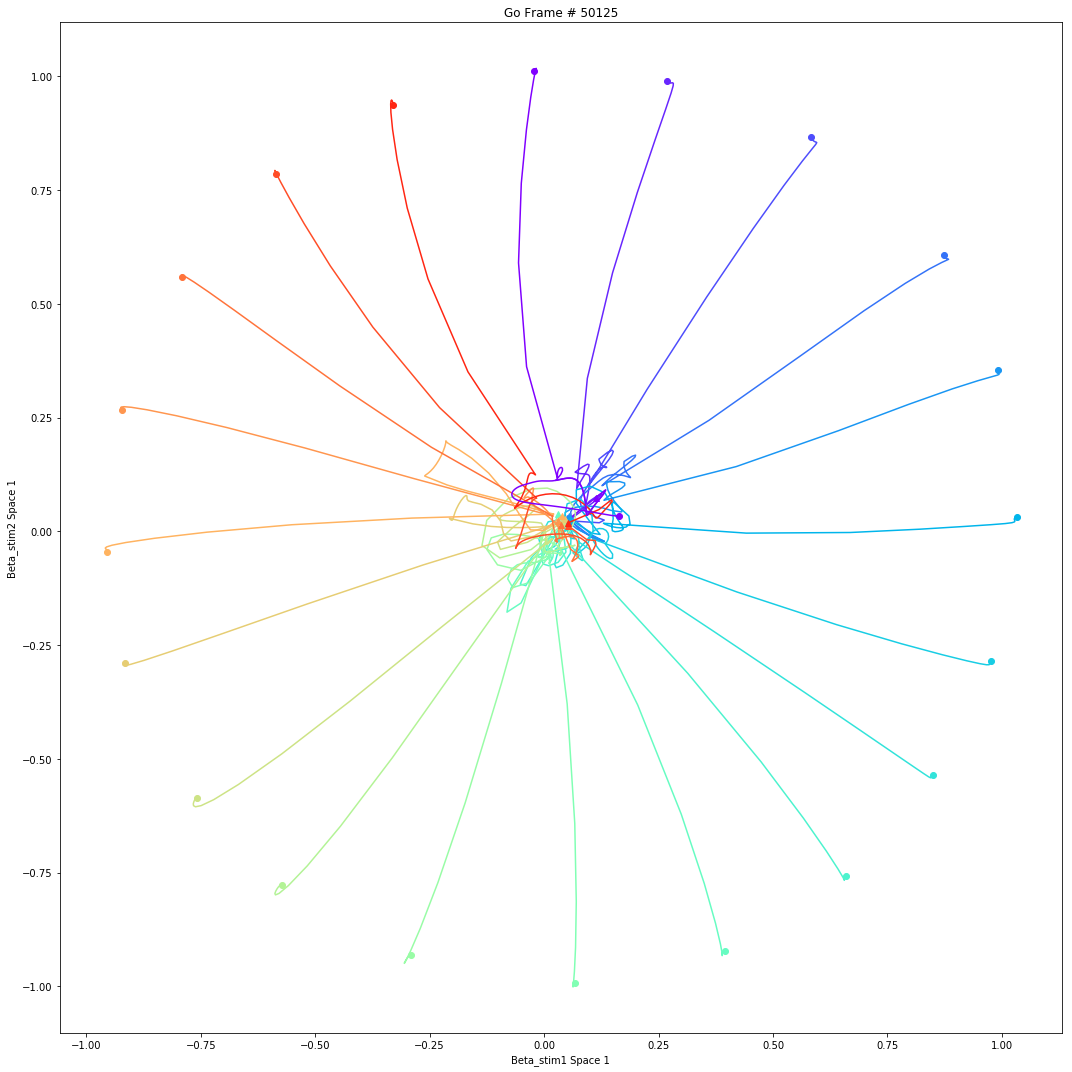

In [61]:
fig = plt.figure(figsize=(15, 15),tight_layout=True,facecolor='white')

inds_use = range(0,1000,50)#onp.argsort(trial.stim_locs[:,0])[0:1000:5]
D = params[2][:,1:3]
# D = np.concatenate((np.expand_dims(Beta_stim2[:,0],axis=1),np.expand_dims(Beta_stim2[:,1],axis=1)),axis = 1)


X = onp.transpose(h_tf[trial.epochs['stim2'][0]-1:trial.epochs['go1'][1],inds_use,:],(1, 0, 2))
plot_N(X,D.T)

X = onp.expand_dims(h_t,axis = 0)
plot_N(X,D.T)

plt.xlabel('Beta_stim1 Space 1')
plt.ylabel('Beta_stim2 Space 1')
plt.title('Go Frame # ' + str(T1_use) + str(T2_use))  
plt.show()

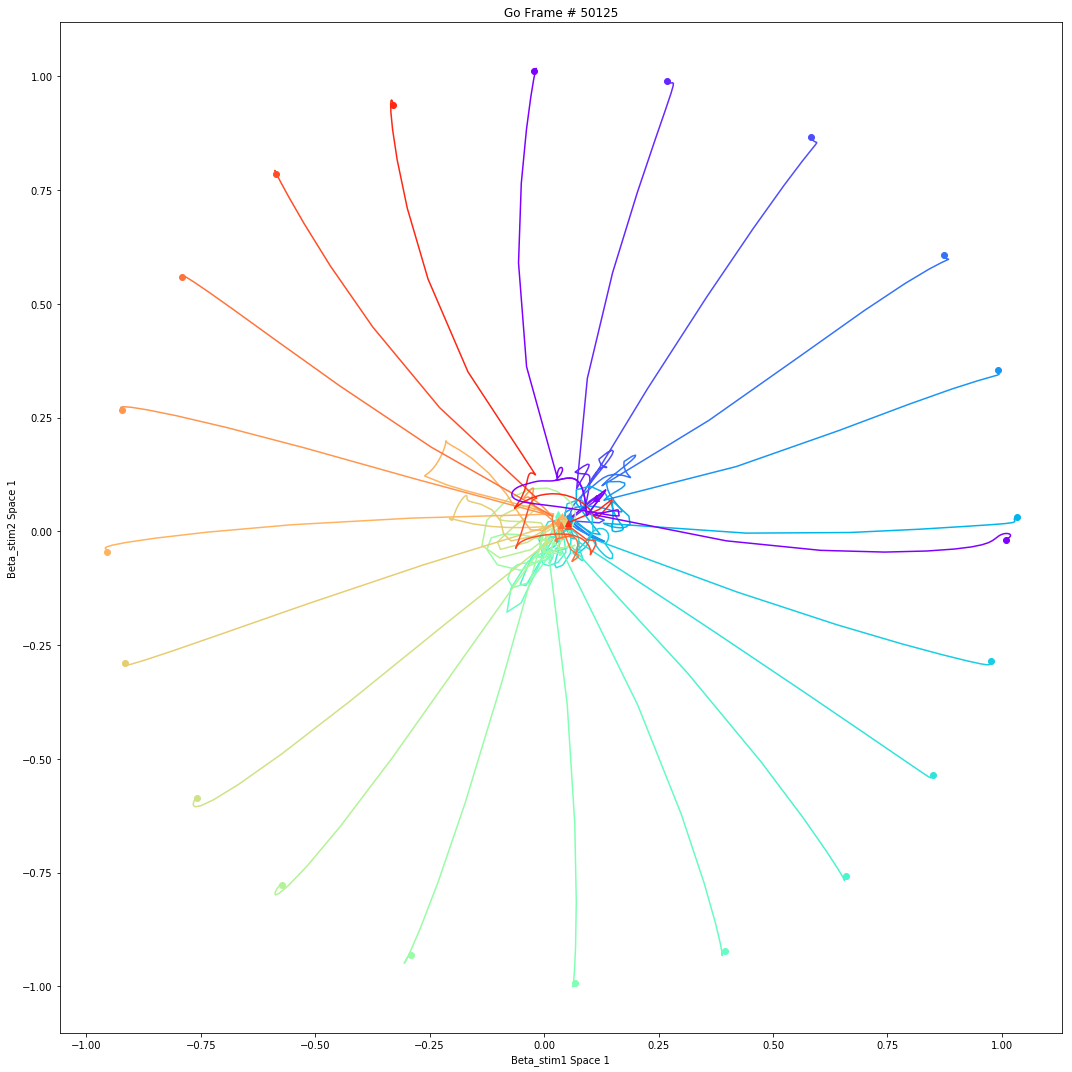

In [90]:
fig = plt.figure(figsize=(15, 15),tight_layout=True,facecolor='white')

inds_use = range(0,1000,50)#onp.argsort(trial.stim_locs[:,0])[0:1000:5]
D = params[2][:,1:3]
# D = np.concatenate((np.expand_dims(Beta_stim2[:,0],axis=1),np.expand_dims(Beta_stim2[:,1],axis=1)),axis = 1)


X = onp.transpose(h_tf[trial.epochs['stim2'][0]-1:trial.epochs['go1'][1],inds_use,:],(1, 0, 2))
plot_N(X,D.T)

X = onp.expand_dims(h_t,axis = 0)
plot_N(X,D.T)

plt.xlabel('Beta_stim1 Space 1')
plt.ylabel('Beta_stim2 Space 1')
plt.title('Go Frame # ' + str(T1_use) + str(T2_use))  
plt.show()

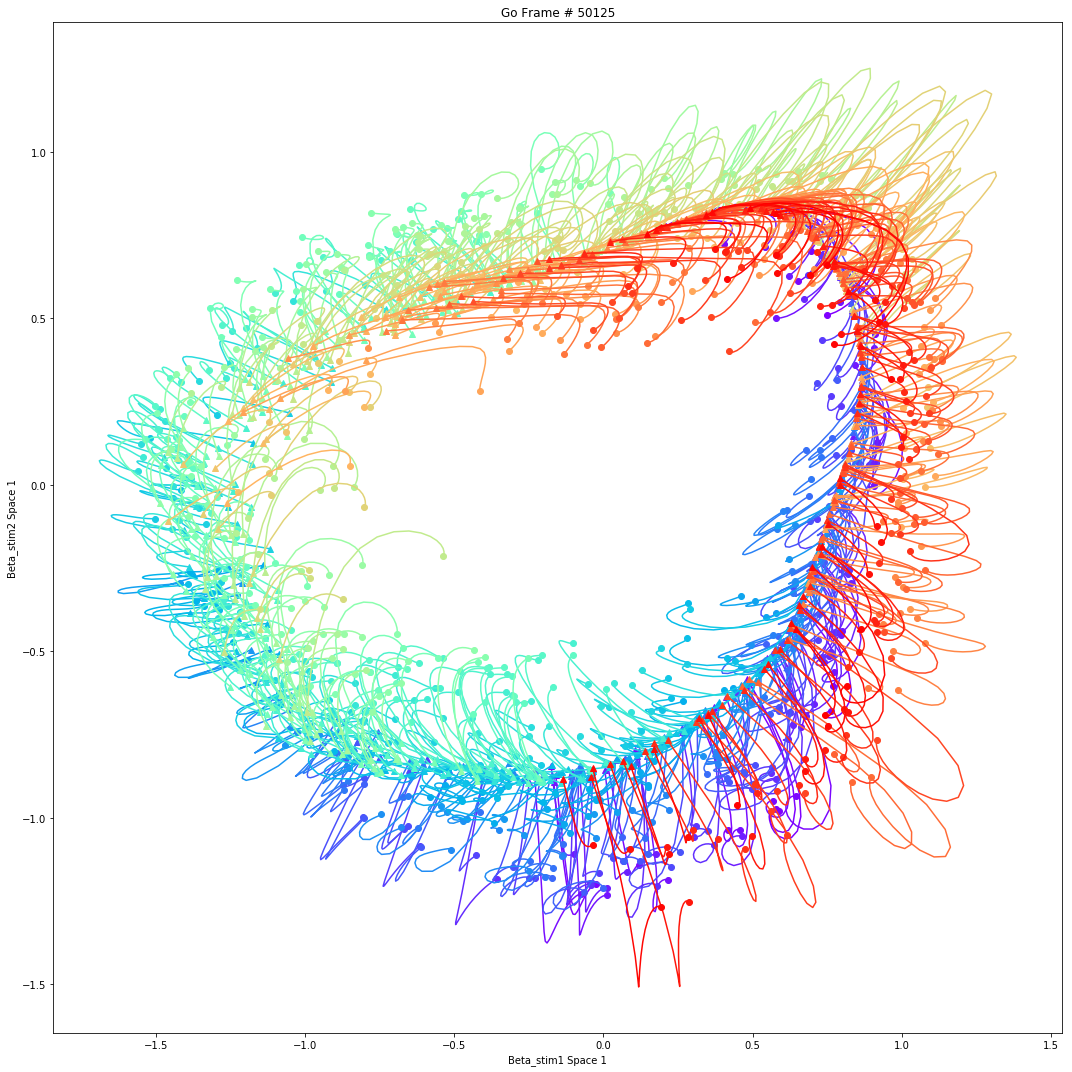

In [109]:
fig = plt.figure(figsize=(15, 15),tight_layout=True,facecolor='white')

# inds_use = range(0,1000,5)
# t_inds = range(trial.epochs['stim1'][0],trial.epochs['stim2'][1])
# D = np.concatenate((np.expand_dims(Beta_stim2[:,0],axis=1),np.expand_dims(Beta_stim2[:,1],axis=1)),axis = 1)
# X = onp.transpose(h_tf[trial.epochs['stim1'][0]:trial.epochs['stim2'][1],inds_use,:],(1, 0, 2))
# plot_N(X,D.T)

inds_use = onp.argsort(trial.stim_locs[:,1])[0:1000]
D = np.concatenate((np.expand_dims(Beta_stim2[:,0],axis=1),np.expand_dims(Beta_stim2[:,1],axis=1)),axis = 1)
X = onp.transpose(h_tf[trial.epochs['stim2'][0]-1:trial.epochs['stim2'][1],inds_use,:],(1, 0, 2))
plot_N(X,D.T)

plt.xlabel('Beta_stim1 Space 1')
plt.ylabel('Beta_stim2 Space 1')
plt.title('Go Frame # ' + str(T1_use) + str(T2_use))  
plt.show()

In [112]:
from scipy.linalg import subspace_angles

sa = subspace_angles(params[2][:,1:3],Beta_stim1[:,:2])
print(sa)

[1.5072157 1.5389136]


In [ ]:
fig = plt.figure(figsize=(15, 15),tight_layout=True,facecolor='white')

D = params[2][:,1:3].T

X = onp.transpose(h_tf[trial.epochs['stim2'][0]:,inds_use,:],(1, 0, 2))
plot_N(X,D)

X = sorted_fps
plot_FP(X, D, fp_losses, rdots, ldots)

plt.xlabel('Beta_stim Space 1')
plt.ylabel('Beta_stim Space 2')
plt.title('Go Frame # ' + str(T_use))  
plt.show()

In [ ]:
def my_vdot(A,B, do_abs=True):
 """Compute dot products that handle complex numbers.  
 Args:
   A : 2d numpy array
   B : 2D numpy array, A.shape[0] == B.shape[0]
 """
 return np.dot(np.conj(A).T, B)
 
def complex_norms(R, keepdims=False):
 """compute the norms of column vectors of R"""
 return np.real(np.sqrt(np.sum(R * np.conj(R), axis=0, keepdims=keepdims)))